In [23]:
from bs4 import BeautifulSoup as bs
import requests
import json
import numpy as np
import pandas as pd
#import pymongo
import base64
import bson
from bson.binary import Binary
import os
import pdfplumber
from urllib.parse import unquote
import re

## Web scrapping

In [2]:
Domain='http://www.bvmt.com.tn/'
URL='http://www.bvmt.com.tn/fr/ab-etats-financiers-semestriels-30-06-2020'
FILETYPE='.pdf'
URL0="http://www.bvmt.com.tn/fr/entreprises/list"


In [3]:
def get_soup(url):
    return bs(requests.get(url).text,'html.parser')

In [4]:
ListID = []
for link in get_soup(URL0).find_all('option'):
    file_link = link.get('uri')
    #print(file_link)
    if file_link is not None:
        new=file_link.replace('/fr/profile-emetteur_profile/','')
        
        ListID.append(new)
        file_name = link.text

In [5]:
# Recupere les liens de chaque entreprise
urls = []
urls1 = []
urls3 = []

for item in ListID:
    site= "http://www.bvmt.com.tn/fr/documents/"+item+"/18/list"
    s = get_soup(site)
    
    #verifie si l'entreprise a un bilan consolidé
    pdf0=s.find("div", {'onclick' : re.compile("consolid",re.IGNORECASE)})

    #print(pdf0)
    
    #si l'entreprise n'a pas de bilan consolidé
    if(pdf0 is None):
        print("pas de bilan consolidé")
    #sinon ajoute le lien de l'entreprise dans la liste
    else :
        print("bilan consolidé")
        pdf1=pdf0.get('onclick')
        newpdf=pdf1.replace('document.location.href=\'','')
        newpdf=newpdf.replace('\'','')
    
        urls3.append(newpdf)
    
 
                   
        #if href.startswith("/fr/content/cours"):
            #urls.append(href)

bilan consolidé
pas de bilan consolidé
pas de bilan consolidé
bilan consolidé
bilan consolidé
bilan consolidé
bilan consolidé
bilan consolidé
pas de bilan consolidé
bilan consolidé
bilan consolidé
bilan consolidé
pas de bilan consolidé
bilan consolidé
pas de bilan consolidé
bilan consolidé
pas de bilan consolidé
bilan consolidé
bilan consolidé
bilan consolidé
bilan consolidé
pas de bilan consolidé
pas de bilan consolidé
bilan consolidé
bilan consolidé
bilan consolidé
pas de bilan consolidé
bilan consolidé
bilan consolidé
bilan consolidé
bilan consolidé
bilan consolidé
bilan consolidé
bilan consolidé
bilan consolidé
pas de bilan consolidé
bilan consolidé
bilan consolidé
bilan consolidé
bilan consolidé
bilan consolidé
pas de bilan consolidé
bilan consolidé
bilan consolidé
pas de bilan consolidé
bilan consolidé
bilan consolidé
bilan consolidé
pas de bilan consolidé
bilan consolidé
bilan consolidé
bilan consolidé
bilan consolidé
pas de bilan consolidé
bilan consolidé
bilan consolidé
pas de

In [6]:
#Cherhce tout les lien pdf

#dictionnaire pdfList
pdfList = {}
for link in urls3:
    pdfPage = get_soup('http://www.bvmt.com.tn'+link)
    
    #cherche le lien de telechargement pdf
    downLoad = pdfPage.find("a", {'href' : re.compile("/default/files/societes/",re.IGNORECASE)})
    
    pdfDownload = downLoad.get('href')
    #trouve le nom de la societé
    compnyName = pdfPage.find('h3').text.strip().split('-',1)
    
    #Formatte le nom de la societe
    
    compnyName[0] =compnyName[0].replace('\"','') 
    compnyName[0] = compnyName[0].replace('\'','')
    compnyName[0] = compnyName[0].replace('–','')
    
    print(compnyName[0])
    #dictionnaire clé:nomSocieté  valeur:lien pdf
    pdfList[compnyName[0]] = pdfDownload
    


Amen Bank 
AIR LIQUIDE TUNISIE 
SOCIETE CHIMIQUE ALKIMIA 
Société Les Ateliers Mécaniques du Sahel 
AUTOMOBILE RESEAU TUNISIEN ET SERVICES 
SOCIETE LACCUMULATEUR TUNISIEN 
ARAB TUNISIAN BANK 
ARAB TUNISIAN LEASE 
BANQUE ATTIJARI DE TUNISIE 
ASSURANCES MAGHREBIA 
BH BANK 
BIAT 
BANQUE NATIONALE AGRICOLE 
BANQUE DE TUNISIE 
BANQUE DE TUNISIE ET DES EMIRATS  
Société Cellcom 
CEREALIS 
COMPAGNIE INTERNATIONALE DE LEASING 
CITY CARS 
DELICE HOLDING 
ELECTROSTAR 
ENNAKL AUTOMOBILES 
ESSOUKNA 
EURO
SOCIETE GENERALE INDUSTRIELLE DE FILTRATION 
HANNIBAL LEASE SA 
Société « LANDOR » 
MAGASIN GENERAL 
Maghreb International Publicité 
SOCIETE NOUVELLE MAISON DE LA VILLE DE TUNIS 
MPBS « Manufacture de Panneaux Bois du Sud » 
STE ONE TECH HOLDING SA 
OFFICE PALST 
POULINA GROUP HOLDING 
Société d’Articles Hygiéniques SAH SA  
SAM 
SERVICOM 
Société de Fabrication des Boissons de Tunisie 
STE IND. DAPPAREILLAGE ET DE MATERIELS ELEC. 
SOCIETE IMMOBILIERE ET DE PARTICIPATIONS 
SOCIETE IMMOBILIERE TUN

## Stockage 

In [8]:
import pymongo
from pymongo import MongoClient
import urllib.request

In [12]:
#fonction qui telecharge le pdf dans le dossier Documents
def Download_pdf(lienPdf,societe):  
    path = 'empty'

    try:
        conn = urllib.request.urlopen(lienPdf)
    except urllib.error.HTTPError as e:
        # Return code error (e.g. 404, 501, ...)
        # ...
        print('HTTPError: {}'.format(e.code))

    except urllib.error.URLError as e:
        # Not an HTTP-specific error (e.g. connection refused)
        # ...
        print('URLError: {}'.format(e.reason))

    else:
        # 200
        # ...
        path = "./Documents/"+societe+".pdf"
        urllib.request.urlretrieve(lienPdf,path)
        
        print('good : '+societe)
    
    return path

    #invoice_pdf = download_file(invoice)

Initialistation de la connection avec la base de données mongoDB

In [9]:
#Connection avec la base de données
cluster = MongoClient('mongodb://localhost:27017/')
db = cluster['Finance']
collection = db['DocuPdf']


In [15]:
#Ajoute dans la base de données
count = 0
postList = []
for key, value in pdfList.items():
    count += 1;
    
    path = Download_pdf(value,key)
    #path = "./Documents/"+key+".pdf"
    postList.append({'_id':count,'companie' : key,'path':path })

collection.insert_many(postList)
    

good : Amen Bank 
good : AIR LIQUIDE TUNISIE 
good : SOCIETE CHIMIQUE ALKIMIA 
good : Société Les Ateliers Mécaniques du Sahel 
good : AUTOMOBILE RESEAU TUNISIEN ET SERVICES 
good : SOCIETE LACCUMULATEUR TUNISIEN 
good : ARAB TUNISIAN BANK 
good : ARAB TUNISIAN LEASE 
good : BANQUE ATTIJARI DE TUNISIE 
good : ASSURANCES MAGHREBIA 
good : BH BANK 
good : BIAT 
good : BANQUE NATIONALE AGRICOLE 
good : BANQUE DE TUNISIE 
good : BANQUE DE TUNISIE ET DES EMIRATS  
good : Société Cellcom 
good : CEREALIS 
good : COMPAGNIE INTERNATIONALE DE LEASING 
good : CITY CARS 
good : DELICE HOLDING 
good : ELECTROSTAR 
good : ENNAKL AUTOMOBILES 
good : ESSOUKNA 
good : EURO
good : SOCIETE GENERALE INDUSTRIELLE DE FILTRATION 
good : HANNIBAL LEASE SA 
good : Société « LANDOR » 
good : MAGASIN GENERAL 
good : Maghreb International Publicité 
good : SOCIETE NOUVELLE MAISON DE LA VILLE DE TUNIS 
good : MPBS « Manufacture de Panneaux Bois du Sud » 
good : STE ONE TECH HOLDING SA 
good : OFFICE PALST 
good :

## Preparation de données

In [3]:
import cv2
from PIL import Image
#import pytesseract 
import sys 
#from pdf2image import convert_from_path 
import os 

In [4]:
import camelot
import re

In [5]:
# Fonction qui detecte la page des actifs du bilan

def get_page(pdf):     
    for pdf_page in pdf.pages:
        text=pdf_page.extract_text()
            #print(x)
        if text is None:
            continue
        else:
            #detecte les mots immobilisation /incorporelles / corporelles/stock
            if 'IMMOBILISATIONS' in text.upper() and 'INCORPORELLES' in text.upper() and 'CORPORELLES'in text.upper() and 'STOCK' in text.upper():
                print(pdf_page.page_number)
                return pdf_page.page_number
            else:
                continue
    return -1
    

In [20]:
#Recuperer de la base de données tous les pdf

resultats = collection.find({})
#detect toutes les page des bilans pour chaque pdf
pages_actifs={}
for societe in resultats:
    with pdfplumber.open(societe['path']) as pdf: 
        pages_actifs[societe['companie']]= get_page(pdf)
        num_page = get_page(pdf)
        #ajoute le numero de la page dans la base de données
        collection.update_one(
            {'_id' : societe['_id']},
            {'$set' : {'pagenbr' : num_page }})
        


2
2
2
2
1
1
2
2
1
1
14
14
22
22
2
2
2
2
2
2
2
2
5
5
2
2
2
2
1
1
10
10
10
10
2
2
12
12
2
2
2
2
2
2
2
2
2
2
2
2
2
2
9
9
2
2
2
2
2
2
2
2
2
2
2
2


In [21]:
#affiche le numero de la page -1 si il ne trouve pas la page
pages_actifs

{'Amen Bank ': -1,
 'AIR LIQUIDE TUNISIE ': 2,
 'SOCIETE CHIMIQUE ALKIMIA ': 2,
 'Société Les Ateliers Mécaniques du Sahel ': 1,
 'AUTOMOBILE RESEAU TUNISIEN ET SERVICES ': 2,
 "SOCIETE L'ACCUMULATEUR TUNISIEN ": 1,
 'ARAB TUNISIAN BANK ': 14,
 'ARAB TUNISIAN LEASE ': -1,
 'BANQUE ATTIJARI DE TUNISIE ': -1,
 'ASSURANCES MAGHREBIA ': -1,
 'BH BANK ': -1,
 'BIAT ': -1,
 'BANQUE NATIONALE AGRICOLE ': 22,
 'BANQUE DE TUNISIE ': -1,
 'BANQUE DE TUNISIE ET DES EMIRATS  ': -1,
 'Société Cellcom ': -1,
 'CEREALIS ': 2,
 'COMPAGNIE INTERNATIONALE DE LEASING ': -1,
 'CITY CARS ': 2,
 'DELICE HOLDING ': 2,
 'ELECTROSTAR ': 2,
 'ENNAKL AUTOMOBILES ': 5,
 'ESSOUKNA ': 2,
 'EURO': 2,
 'SOCIETE GENERALE INDUSTRIELLE DE FILTRATION ': 1,
 'HANNIBAL LEASE SA ': -1,
 "Société « LAND'OR » ": 10,
 'MAGASIN GENERAL ': 10,
 'Maghreb International Publicité ': 2,
 'SOCIETE NOUVELLE MAISON DE LA VILLE DE TUNIS ': 12,
 'MPBS « Manufacture de Panneaux Bois du Sud » ': 2,
 'STE ONE TECH HOLDING SA ': -1,
 'OFFICE

## Extraction des variables 

In [66]:
#Nom des variables a extraire
# !!!! a verifier/modifier !!!!
var_Actifs = ["total.*actifs$",'total.*actifs courants$',
                 "liquidit[eé]s.*liquidit[eé]s","^stock.*",
                "clients Et comptes Rattach[ée]s"]

var_Passifs = ["^total.*capitaux.*propre.*","total.*passifs courants",
                 "total.*passifs non courants",
                "fournisseurs et comptes rattach[eé]s"]


var_Resultat = ["r[eé]sultat.*net","total.*produits d'exploitation","achats.*",
                          ".*amorti.*provisions",
                          "charges financi[èe]res nettes",'r[ée]sultat.*exploitation']


var_CashFlow = ["flux de trésorerie.*[provenant|liée].*exploitation"]

In [67]:
#retourne la colonne de la derniere année du bilan(ex : 2019) du dataframe de camelot
#prend un argument dataframe
def get_indiceColonne(df_bilan):   
    nb_lignes = df_bilan.shape[0]
    nb_colonnes = df_bilan.shape[1]
    for i in np.arange(0,nb_lignes):   
        for j in np.arange(0,nb_colonnes):
            string = df_bilan.loc[i,j]
            
            if(len(string)>4):
                #remplace les characteres non ascii par ''
                string = ''.join(char for char in string if ord(char) < 128)
                string = string.replace(" ","")
                string = string.replace(",",".")

                try:
                    float(string)
                    
                    return j
                except ValueError:
                    
                    continue
    return 0

In [68]:
#retourne la valeur de la variable recherché
#prend en argument le df camelot et le nom  de la variable a rechercher

def get_Variable(df_bilan,Nom_variable):
    #appel de la fonction get_indiceColonne
    col = get_indiceColonne(df_bilan)
    #print(col)
    
    nb_lignes = df_bilan.shape[0]
    nb_colonnes = df_bilan.shape[1]
    #iteration sur les cellules du documents
    for i in np.arange(0,nb_lignes):
        for j in np.arange(0,nb_colonnes):
            variable = 0
            #print(i)
            cell = df_bilan.loc[i,j]
            if(chr(160) in df_bilan.loc[i,j]):
                #print('Danger')
                cell = df_bilan.loc[i,j].replace(chr(160),' ')
            
            #verifie la variable a chercher avec l'expression reguliere
            if(re.search(Nom_variable,cell,re.IGNORECASE)):
                #print("col : {}".format(col))
                variable = df_bilan.loc[i,col]
                #print(variable)
                if(variable == '' and i+1 < nb_lignes):

                    variable = df_bilan.loc[i+1,col]

                else :
                    return variable
    return 0

In [69]:
indx = [
    'societe',
    'total des actifs',
    'total des actifs courant',
    'liquidités',
    'stocks',
    'clients Et comptes Rattachés',
    'capitaux propres',
    'total des passifs courants',
    'total des passifs non courants',
    'fournisseurs et comptes rattachés',
    'résultat net',
    'total des produits exploitation',
    'achats de marchandises',
    'dotations aux amortissements et aux provisions',
    'charges financières nettes',
    'resultat exploitation', 
    'total des flux de trésorerie liés aux opérations exploitation'
]

In [183]:
#Camelot qui extrait le dataframe du pdf
#peut accepter plusieurs page a la fois
 
#recupère toutes les societe avec un numero de page != -1
resultats = collection.find({'pagenbr' : {'$ne' : -1}})

row_list = []
for pdf in resultats:
    row = []
    page_actif =str(pdf['pagenbr'])
    page_passif = str(pdf['pagenbr']+1)
    page_res = str(pdf['pagenbr']+2)
    page_cashFlow = str(pdf['pagenbr']+3)
    all_pages = page_actif +','+ page_passif+',' + page_res+ ','+ page_cashFlow
    print(all_pages)
    tablesBilan2 = camelot.read_pdf(pdf['path'],pages =all_pages ,flavor = "stream",edge_tol=2)
    
    #extrait les variable de la pages des actifs dans un dictionaire
    try : 
        row.append(pdf['companie'])
        for variable in var_Actifs:
            row.append(get_Variable(tablesBilan2[0].df,variable)) 
        #extrait les vairable de la page des passifs
        for variable in var_Passifs: 
            row.append(get_Variable(tablesBilan2[1].df,variable))
         #extrait les vairable de la page des resultats  
        for variable in var_Resultat: 
                row.append(get_Variable(tablesBilan2[2].df,variable))
            
        #extrait les vairable de la page des passifs    
        for variable in var_CashFlow: 
            row.append(get_Variable(tablesBilan2[3].df,variable))
        
    except Exception as e:
        print(e)
        print(pdf['path'])
    row_list.append(row)  
#creation du data frame
df = pd.DataFrame(row_list,columns = indx)

2,3,4,5
2,3,4,5
1,2,3,4
2,3,4,5
1,2,3,4
14,15,16,17
22,23,24,25
2,3,4,5
2,3,4,5
2,3,4,5
2,3,4,5
5,6,7,8
2,3,4,5
2,3,4,5
1,2,3,4
10,11,12,13
10,11,12,13
2,3,4,5
12,13,14,15
2,3,4,5
2,3,4,5
2,3,4,5
2,3,4,5
2,3,4,5
2,3,4,5
2,3,4,5
9,10,11,12
2,3,4,5
2,3,4,5
2,3,4,5
2,3,4,5
2,3,4,5
2,3,4,5


In [184]:
df.head()

,societe,total des actifs,total des actifs courant,liquidités,stocks,clients Et comptes Rattachés,capitaux propres,total des passifs courants,total des passifs non courants,fournisseurs et comptes rattachés,résultat net,total des produits exploitation,achats de marchandises,dotations aux amortissements et aux provisions,charges financières nettes,resultat exploitation,total des flux de trésorerie liés aux opérations exploitation
0,AIR LIQUIDE TUNISIE,107 706 997,76 961 599,12 402 207,19 778 539,47 987 333,107 706 997,34 686 543,11 949 697,17 538 614,12 531 661,0,0,0,<1 087 176>,18 687 872,8 438 319
1,SOCIETE CHIMIQUE ALKIMIA,236 176 354,118 229 161,23 252 154,40 281 150,55 944 253,236 176 354,198 304 925,53 543 157,150 657 628,(29 226 510),176 909 511,133 894 281,8 437 546,(11 188 486),(19 094 786),0
2,Société Les Ateliers Mécaniques du Sahel,64 654 264,46 815 432,558 676,35 539 779,10 804 676,15 589 919,49 521 405,6 137 735,0,-6 594 795,26 457 718,12 604 662,5 253 582,(3 314 347),-5 953 059,-7 016 229
3,AUTOMOBILE RESEAU TUNISIEN ET SERVICES,288 524 645,254 955 234,32 348 891,95 418 930,32 019 591,150 198 789,103 440 302,390 000,93 271 528,29 971 889,244 969 888,(211 580 228),0,(5 258),35 140 756,0
4,SOCIETE L'ACCUMULATEUR TUNISIEN,160 891 146,129 760 669,20 908 031,44 413 225,62 945 729,52 727 413,72 685 453,30 319 970,12 135 374,3 575 880,154 544 493,95 549 542,0,-8 186 632,14 822 771,5 462 324


In [185]:

spec_chars = ["!",'"',"#","%","&","'","(",")",
              "*","+",",",".","/",":",";","<",
              "=",">","?","@","[","\\","]","^","_",
              "`","{","|","}","~","–"]
columns= [
'total des actifs',
'total des actifs courant',
'liquidités',
'stocks',
'clients Et comptes Rattachés',
'capitaux propres',
'total des passifs courants',
'total des passifs non courants',
'fournisseurs et comptes rattachés',
'résultat net',
'resultat exploitation',
'total des produits exploitation',
'achats de marchandises',
'dotations aux amortissements et aux provisions',
'charges financières nettes',
'total des flux de trésorerie liés aux opérations exploitation']

for i in columns:
    for char in spec_chars:
        df[i]= df[i].str.replace(char, ' ')
        

In [186]:
for i in columns:
    df[i]= df[i].str.replace(" ", '')
    
        

In [187]:
df.head()

,societe,total des actifs,total des actifs courant,liquidités,stocks,clients Et comptes Rattachés,capitaux propres,total des passifs courants,total des passifs non courants,fournisseurs et comptes rattachés,résultat net,total des produits exploitation,achats de marchandises,dotations aux amortissements et aux provisions,charges financières nettes,resultat exploitation,total des flux de trésorerie liés aux opérations exploitation
0,AIR LIQUIDE TUNISIE,107706997,76961599,12402207,19778539,47987333,107706997,34686543,11949697,17538614,12531661,NaN,NaN,NaN,1087176,18687872,8438319
1,SOCIETE CHIMIQUE ALKIMIA,236176354,118229161,23252154,40281150,55944253,236176354,198304925,53543157,150657628,29226510,176909511,133894281,8437546,11188486,19094786,NaN
2,Société Les Ateliers Mécaniques du Sahel,64654264,46815432,558676,35539779,10804676,15589919,49521405,6137735,NaN,-6594795,26457718,12604662,5253582,3314347,-5953059,-7016229
3,AUTOMOBILE RESEAU TUNISIEN ET SERVICES,288524645,254955234,32348891,95418930,32019591,150198789,103440302,390000,93271528,29971889,244969888,211580228,NaN,5258,35140756,NaN
4,SOCIETE L'ACCUMULATEUR TUNISIEN,160891146,129760669,20908031,44413225,62945729,52727413,72685453,30319970,12135374,3575880,154544493,95549542,NaN,-8186632,14822771,5462324


In [ ]:
df.to_excel("PDF_Version_Final.xlsx")

In [2]:
Data = pd.read_excel("PDF_Version_Final.xlsx")

In [3]:
Data.head()

,Unnamed: 0,societe,total des actifs,total des actifs courant,liquidités,stocks,clients Et comptes Rattachés,capitaux propres,total des passifs courants,total des passifs non courants,fournisseurs et comptes rattachés,résultat net,total des produits exploitation,achats de marchandises,dotations aux amortissements et aux provisions,charges financières nettes,resultat exploitation,total des flux de trésorerie liés aux opérations exploitation
0,0,AIR LIQUIDE TUNISIE,107706997,76961599,12402207,19778539,47987333,107706997,34686543,11949697,17538614,12531661,NaN,NaN,NaN,1087176,18687872,8438319.0
1,1,SOCIETE CHIMIQUE ALKIMIA,236176354,118229161,23252154,40281150,55944253,236176354,198304925,53543157,150657628,29226510,176909511,133894281,8437546,11188486,19094786,NaN
2,2,Société Les Ateliers Mécaniques du Sahel,64654264,46815432,558676,35539779,10804676,15589919,49521405,6137735,NaN,-6594795,26457718,12604662,5253582,3314347,-5953059,-7016229.0
3,3,AUTOMOBILE RESEAU TUNISIEN ET SERVICES,288524645,254955234,32348891,95418930,32019591,150198789,103440302,390000,93271528,29971889,244969888,211580228,NaN,5258,35140756,NaN
4,4,SOCIETE L'ACCUMULATEUR TUNISIEN,160891146,129760669,20908031,44413225,62945729,52727413,72685453,30319970,12135374,3575880,154544493,95549542,NaN,-8186632,14822771,5462324.0


In [4]:
Data.shape

(33, 18)

In [5]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 18 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   Unnamed: 0                                                     33 non-null     int64  
 1   societe                                                        33 non-null     object 
 2   total des actifs                                               27 non-null     object 
 3   total des actifs courant                                       28 non-null     object 
 4   liquidités                                                     30 non-null     object 
 5   stocks                                                         29 non-null     object 
 6   clients Et comptes Rattachés                                   30 non-null     object 
 7   capitaux propres                                               2

In [6]:
Data.describe()

,Unnamed: 0,total des flux de trésorerie liés aux opérations exploitation
count,33.00000,2.000000e+01
mean,16.00000,6.897525e+08
std,9.66954,2.101600e+09
min,0.00000,-7.510919e+06
25%,8.00000,2.388982e+05
50%,16.00000,7.416888e+06
75%,24.00000,2.778800e+07
max,32.00000,8.090185e+09


In [7]:
Data.dtypes

Unnamed: 0                                                         int64
societe                                                           object
total des actifs                                                  object
total des actifs courant                                          object
liquidités                                                        object
stocks                                                            object
clients Et comptes Rattachés                                      object
capitaux propres                                                  object
total des passifs courants                                        object
total des passifs non courants                                    object
fournisseurs et comptes rattachés                                 object
résultat net                                                      object
total des produits exploitation                                   object
achats de marchandises                             

In [8]:
Data.head()

,Unnamed: 0,societe,total des actifs,total des actifs courant,liquidités,stocks,clients Et comptes Rattachés,capitaux propres,total des passifs courants,total des passifs non courants,fournisseurs et comptes rattachés,résultat net,total des produits exploitation,achats de marchandises,dotations aux amortissements et aux provisions,charges financières nettes,resultat exploitation,total des flux de trésorerie liés aux opérations exploitation
0,0,AIR LIQUIDE TUNISIE,107706997,76961599,12402207,19778539,47987333,107706997,34686543,11949697,17538614,12531661,NaN,NaN,NaN,1087176,18687872,8438319.0
1,1,SOCIETE CHIMIQUE ALKIMIA,236176354,118229161,23252154,40281150,55944253,236176354,198304925,53543157,150657628,29226510,176909511,133894281,8437546,11188486,19094786,NaN
2,2,Société Les Ateliers Mécaniques du Sahel,64654264,46815432,558676,35539779,10804676,15589919,49521405,6137735,NaN,-6594795,26457718,12604662,5253582,3314347,-5953059,-7016229.0
3,3,AUTOMOBILE RESEAU TUNISIEN ET SERVICES,288524645,254955234,32348891,95418930,32019591,150198789,103440302,390000,93271528,29971889,244969888,211580228,NaN,5258,35140756,NaN
4,4,SOCIETE L'ACCUMULATEUR TUNISIEN,160891146,129760669,20908031,44413225,62945729,52727413,72685453,30319970,12135374,3575880,154544493,95549542,NaN,-8186632,14822771,5462324.0


In [9]:
Data.duplicated().any()
   

False

In [10]:
Data.isnull().sum()

Unnamed: 0                                                        0
societe                                                           0
total des actifs                                                  6
total des actifs courant                                          5
liquidités                                                        3
stocks                                                            4
clients Et comptes Rattachés                                      3
capitaux propres                                                  5
total des passifs courants                                        4
total des passifs non courants                                    4
fournisseurs et comptes rattachés                                 6
résultat net                                                      9
total des produits exploitation                                   9
achats de marchandises                                            8
dotations aux amortissements et aux provisions  

In [11]:
Data.drop('societe', axis='columns', inplace=True)

In [12]:
Data.drop('Unnamed: 0', axis='columns', inplace=True)

In [13]:
Data.head()

,total des actifs,total des actifs courant,liquidités,stocks,clients Et comptes Rattachés,capitaux propres,total des passifs courants,total des passifs non courants,fournisseurs et comptes rattachés,résultat net,total des produits exploitation,achats de marchandises,dotations aux amortissements et aux provisions,charges financières nettes,resultat exploitation,total des flux de trésorerie liés aux opérations exploitation
0,107706997,76961599,12402207,19778539,47987333,107706997,34686543,11949697,17538614,12531661,NaN,NaN,NaN,1087176,18687872,8438319.0
1,236176354,118229161,23252154,40281150,55944253,236176354,198304925,53543157,150657628,29226510,176909511,133894281,8437546,11188486,19094786,NaN
2,64654264,46815432,558676,35539779,10804676,15589919,49521405,6137735,NaN,-6594795,26457718,12604662,5253582,3314347,-5953059,-7016229.0
3,288524645,254955234,32348891,95418930,32019591,150198789,103440302,390000,93271528,29971889,244969888,211580228,NaN,5258,35140756,NaN
4,160891146,129760669,20908031,44413225,62945729,52727413,72685453,30319970,12135374,3575880,154544493,95549542,NaN,-8186632,14822771,5462324.0


In [14]:
#from string to float
Data['total des actifs'] = pd.to_numeric(Data['total des actifs'],errors = 'coerce')
Data['total des actifs courant'] = pd.to_numeric(Data['total des actifs courant'],errors = 'coerce')
Data['liquidités'] = pd.to_numeric(Data['liquidités'],errors = 'coerce')
Data['stocks'] = pd.to_numeric(Data['stocks'],errors = 'coerce')                                    
Data['clients Et comptes Rattachés'] = pd.to_numeric(Data['clients Et comptes Rattachés'],errors = 'coerce')
Data['capitaux propres'] = pd.to_numeric(Data['capitaux propres'],errors = 'coerce')
Data['total des passifs courants'] = pd.to_numeric(Data['total des passifs courants'],errors = 'coerce')
Data['fournisseurs et comptes rattachés'] = pd.to_numeric(Data['fournisseurs et comptes rattachés'],errors = 'coerce')                                    
Data['total des passifs non courants'] = pd.to_numeric(Data['total des passifs non courants'],errors = 'coerce')
Data['fournisseurs et comptes rattachés'] = pd.to_numeric(Data['fournisseurs et comptes rattachés'],errors = 'coerce')
Data['résultat net'] = pd.to_numeric(Data['résultat net'],errors = 'coerce')                                    
Data['total des produits exploitation'] = pd.to_numeric(Data['total des produits exploitation'],errors = 'coerce')                                    
Data['achats de marchandises'] = pd.to_numeric(Data['achats de marchandises'],errors = 'coerce')
Data['dotations aux amortissements et aux provisions'] = pd.to_numeric(Data['dotations aux amortissements et aux provisions'],errors = 'coerce')
Data['charges financières nettes'] = pd.to_numeric(Data['charges financières nettes'],errors = 'coerce')
Data[ 'resultat exploitation'] = pd.to_numeric(Data['resultat exploitation'],errors = 'coerce')
Data['total des flux de trésorerie liés aux opérations exploitation'] = pd.to_numeric(Data['total des flux de trésorerie liés aux opérations exploitation'],errors = 'coerce')


In [15]:
Data.nunique()

total des actifs                                                 26
total des actifs courant                                         27
liquidités                                                       28
stocks                                                           27
clients Et comptes Rattachés                                     28
capitaux propres                                                 27
total des passifs courants                                       28
total des passifs non courants                                   27
fournisseurs et comptes rattachés                                26
résultat net                                                     23
total des produits exploitation                                  23
achats de marchandises                                           24
dotations aux amortissements et aux provisions                   20
charges financières nettes                                       27
resultat exploitation                           

In [16]:
print(Data.dtypes)

total des actifs                                                 float64
total des actifs courant                                         float64
liquidités                                                       float64
stocks                                                           float64
clients Et comptes Rattachés                                     float64
capitaux propres                                                 float64
total des passifs courants                                       float64
total des passifs non courants                                   float64
fournisseurs et comptes rattachés                                float64
résultat net                                                     float64
total des produits exploitation                                  float64
achats de marchandises                                           float64
dotations aux amortissements et aux provisions                   float64
charges financières nettes                         

## Multiple imputation¶


#### BayesianRidge

In [19]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor

In [20]:
imp = IterativeImputer(max_iter=20, random_state=0,tol=1e-2)
liste = imp.fit_transform(Data)


In [21]:
BayesianRidge_Data=pd.DataFrame(liste,columns=Data.columns.to_list())

In [22]:
BayesianRidge_Data.head()

,total des actifs,total des actifs courant,liquidités,stocks,clients Et comptes Rattachés,capitaux propres,total des passifs courants,total des passifs non courants,fournisseurs et comptes rattachés,résultat net,total des produits exploitation,achats de marchandises,dotations aux amortissements et aux provisions,charges financières nettes,resultat exploitation,total des flux de trésorerie liés aux opérations exploitation
0,107706997.0,76961599.0,12402207.0,19778539.0,47987333.0,107706997.0,34686543.0,11949697.0,1.753861e+07,12531661.0,7.890976e+07,8.273827e+07,5.316119e+06,1087176.0,18687872.0,8.438319e+06
1,236176354.0,118229161.0,23252154.0,40281150.0,55944253.0,236176354.0,198304925.0,53543157.0,1.506576e+08,29226510.0,1.769095e+08,1.338943e+08,8.437546e+06,11188486.0,19094786.0,2.305367e+07
2,64654264.0,46815432.0,558676.0,35539779.0,10804676.0,15589919.0,49521405.0,6137735.0,1.743081e+07,-6594795.0,2.645772e+07,1.260466e+07,5.253582e+06,3314347.0,-5953059.0,-7.016229e+06
3,288524645.0,254955234.0,32348891.0,95418930.0,32019591.0,150198789.0,103440302.0,390000.0,9.327153e+07,29971889.0,2.449699e+08,2.115802e+08,1.160594e+07,5258.0,35140756.0,6.546593e+05
4,160891146.0,129760669.0,20908031.0,44413225.0,62945729.0,52727413.0,72685453.0,30319970.0,1.213537e+07,3575880.0,1.545445e+08,9.554954e+07,5.258616e+06,-8186632.0,14822771.0,5.462324e+06


#### DecisionTreeRegressor

In [23]:
imp = IterativeImputer(estimator=DecisionTreeRegressor(),max_iter=20, random_state=0,tol=1e-2)
liste = imp.fit_transform(Data)

In [24]:
 DecisionTreeRegressor_Data=pd.DataFrame(liste,columns=Data.columns.to_list())

In [25]:
 DecisionTreeRegressor_Data.head()

,total des actifs,total des actifs courant,liquidités,stocks,clients Et comptes Rattachés,capitaux propres,total des passifs courants,total des passifs non courants,fournisseurs et comptes rattachés,résultat net,total des produits exploitation,achats de marchandises,dotations aux amortissements et aux provisions,charges financières nettes,resultat exploitation,total des flux de trésorerie liés aux opérations exploitation
0,107706997.0,76961599.0,12402207.0,19778539.0,47987333.0,107706997.0,34686543.0,11949697.0,17538614.0,12531661.0,125492486.0,-46692843.0,-5314900.0,1087176.0,18687872.0,8438319.0
1,236176354.0,118229161.0,23252154.0,40281150.0,55944253.0,236176354.0,198304925.0,53543157.0,150657628.0,29226510.0,176909511.0,133894281.0,8437546.0,11188486.0,19094786.0,8277296.0
2,64654264.0,46815432.0,558676.0,35539779.0,10804676.0,15589919.0,49521405.0,6137735.0,10852745.0,-6594795.0,26457718.0,12604662.0,5253582.0,3314347.0,-5953059.0,-7016229.0
3,288524645.0,254955234.0,32348891.0,95418930.0,32019591.0,150198789.0,103440302.0,390000.0,93271528.0,29971889.0,244969888.0,211580228.0,-5314900.0,5258.0,35140756.0,6556480.0
4,160891146.0,129760669.0,20908031.0,44413225.0,62945729.0,52727413.0,72685453.0,30319970.0,12135374.0,3575880.0,154544493.0,95549542.0,-6828247.0,-8186632.0,14822771.0,5462324.0


#### ExtraTreesRegressor

In [26]:
imp = IterativeImputer(estimator=ExtraTreesRegressor(),max_iter=20, random_state=0,tol=1e-2)
liste3 = imp.fit_transform(Data)

In [27]:
ExtraTreesRegressor_Data=pd.DataFrame(liste,columns=Data.columns.to_list())

In [28]:
ExtraTreesRegressor_Data.head()

,total des actifs,total des actifs courant,liquidités,stocks,clients Et comptes Rattachés,capitaux propres,total des passifs courants,total des passifs non courants,fournisseurs et comptes rattachés,résultat net,total des produits exploitation,achats de marchandises,dotations aux amortissements et aux provisions,charges financières nettes,resultat exploitation,total des flux de trésorerie liés aux opérations exploitation
0,107706997.0,76961599.0,12402207.0,19778539.0,47987333.0,107706997.0,34686543.0,11949697.0,17538614.0,12531661.0,125492486.0,-46692843.0,-5314900.0,1087176.0,18687872.0,8438319.0
1,236176354.0,118229161.0,23252154.0,40281150.0,55944253.0,236176354.0,198304925.0,53543157.0,150657628.0,29226510.0,176909511.0,133894281.0,8437546.0,11188486.0,19094786.0,8277296.0
2,64654264.0,46815432.0,558676.0,35539779.0,10804676.0,15589919.0,49521405.0,6137735.0,10852745.0,-6594795.0,26457718.0,12604662.0,5253582.0,3314347.0,-5953059.0,-7016229.0
3,288524645.0,254955234.0,32348891.0,95418930.0,32019591.0,150198789.0,103440302.0,390000.0,93271528.0,29971889.0,244969888.0,211580228.0,-5314900.0,5258.0,35140756.0,6556480.0
4,160891146.0,129760669.0,20908031.0,44413225.0,62945729.0,52727413.0,72685453.0,30319970.0,12135374.0,3575880.0,154544493.0,95549542.0,-6828247.0,-8186632.0,14822771.0,5462324.0


#### KNeighborsRegressor

In [29]:
imp = IterativeImputer(estimator=KNeighborsRegressor(),max_iter=20, random_state=0,tol=1e-2)
liste = imp.fit_transform(Data)

In [30]:
KNeighborsRegressor_Data=pd.DataFrame(liste,columns=Data.columns.to_list())

In [31]:
KNeighborsRegressor_Data.head()

,total des actifs,total des actifs courant,liquidités,stocks,clients Et comptes Rattachés,capitaux propres,total des passifs courants,total des passifs non courants,fournisseurs et comptes rattachés,résultat net,total des produits exploitation,achats de marchandises,dotations aux amortissements et aux provisions,charges financières nettes,resultat exploitation,total des flux de trésorerie liés aux opérations exploitation
0,107706997.0,76961599.0,12402207.0,19778539.0,47987333.0,107706997.0,34686543.0,11949697.0,17538614.0,12531661.0,75189990.2,43250986.6,2493088.0,1087176.0,18687872.0,8438319.0
1,236176354.0,118229161.0,23252154.0,40281150.0,55944253.0,236176354.0,198304925.0,53543157.0,150657628.0,29226510.0,176909511.0,133894281.0,8437546.0,11188486.0,19094786.0,7991152.2
2,64654264.0,46815432.0,558676.0,35539779.0,10804676.0,15589919.0,49521405.0,6137735.0,3548903.4,-6594795.0,26457718.0,12604662.0,5253582.0,3314347.0,-5953059.0,-7016229.0
3,288524645.0,254955234.0,32348891.0,95418930.0,32019591.0,150198789.0,103440302.0,390000.0,93271528.0,29971889.0,244969888.0,211580228.0,6606219.2,5258.0,35140756.0,7991152.2
4,160891146.0,129760669.0,20908031.0,44413225.0,62945729.0,52727413.0,72685453.0,30319970.0,12135374.0,3575880.0,154544493.0,95549542.0,3356084.6,-8186632.0,14822771.0,5462324.0


### Scoring

Z-Score = 1.2A + 1.4B + 3.3C + 0.6D + 1.0E

Where:

A = working capital / total assets





B = retained earnings / total assets

C = earnings before interest and tax / total assets

D = market value of equity / total liabilities

E = sales / total assets

In [32]:
BayesianRidge_Data['total des actifs non courant']=BayesianRidge_Data['total des actifs'] - BayesianRidge_Data['total des actifs courant']
BayesianRidge_Data['Fonds de roulement']=BayesianRidge_Data['capitaux propres'] + BayesianRidge_Data['total des passifs courants'] - BayesianRidge_Data['total des actifs non courant']
BayesianRidge_Data['charges exploitation'] =BayesianRidge_Data['total des produits exploitation'] - BayesianRidge_Data['résultat net']
BayesianRidge_Data['EBIT']= BayesianRidge_Data['total des produits exploitation'] - BayesianRidge_Data['charges exploitation'] - BayesianRidge_Data['dotations aux amortissements et aux provisions']
BayesianRidge_Data['total des passifs']= BayesianRidge_Data['total des passifs courants'] +BayesianRidge_Data['total des passifs non courants'] 


BayesianRidge_Data['A']=BayesianRidge_Data['Fonds de roulement'] / BayesianRidge_Data['total des actifs']
BayesianRidge_Data['B']=BayesianRidge_Data['résultat net'] / BayesianRidge_Data['total des actifs']
BayesianRidge_Data['C']=BayesianRidge_Data['EBIT'] /BayesianRidge_Data['total des actifs']
BayesianRidge_Data['D']=BayesianRidge_Data['capitaux propres'] / BayesianRidge_Data['total des passifs']
BayesianRidge_Data['E']=BayesianRidge_Data['total des produits exploitation'] / BayesianRidge_Data['total des actifs']


BayesianRidge_Data['scoring']= 1.2*BayesianRidge_Data['A'] + 1.4*BayesianRidge_Data['B'] + 3.3*BayesianRidge_Data['C'] + 0.6*BayesianRidge_Data['D'] + 1.0*BayesianRidge_Data['E']  

In [33]:
DecisionTreeRegressor_Data['total des actifs non courant']=DecisionTreeRegressor_Data['total des actifs'] - DecisionTreeRegressor_Data['total des actifs courant']
DecisionTreeRegressor_Data['Fonds de roulement']=DecisionTreeRegressor_Data['capitaux propres'] + DecisionTreeRegressor_Data['total des passifs courants'] - DecisionTreeRegressor_Data['total des actifs non courant']
DecisionTreeRegressor_Data['charges exploitation'] =DecisionTreeRegressor_Data['total des produits exploitation'] - DecisionTreeRegressor_Data['résultat net']
DecisionTreeRegressor_Data['EBIT']= DecisionTreeRegressor_Data['total des produits exploitation'] - DecisionTreeRegressor_Data['charges exploitation'] - DecisionTreeRegressor_Data['dotations aux amortissements et aux provisions']
DecisionTreeRegressor_Data['total des passifs']= DecisionTreeRegressor_Data['total des passifs courants'] +DecisionTreeRegressor_Data['total des passifs non courants'] 


DecisionTreeRegressor_Data['A']=DecisionTreeRegressor_Data['Fonds de roulement'] / DecisionTreeRegressor_Data['total des actifs']
DecisionTreeRegressor_Data['B']=DecisionTreeRegressor_Data['résultat net'] / DecisionTreeRegressor_Data['total des actifs']
DecisionTreeRegressor_Data['C']=DecisionTreeRegressor_Data['EBIT'] /DecisionTreeRegressor_Data['total des actifs']
DecisionTreeRegressor_Data['D']=DecisionTreeRegressor_Data['capitaux propres'] / DecisionTreeRegressor_Data['total des passifs']
DecisionTreeRegressor_Data['E']=DecisionTreeRegressor_Data['total des produits exploitation'] / DecisionTreeRegressor_Data['total des actifs']


DecisionTreeRegressor_Data['scoring']= 1.2*DecisionTreeRegressor_Data['A'] + 1.4*DecisionTreeRegressor_Data['B'] + 3.3*DecisionTreeRegressor_Data['C'] + 0.6*DecisionTreeRegressor_Data['D'] + 1.0*DecisionTreeRegressor_Data['E'] 

In [34]:
ExtraTreesRegressor_Data['total des actifs non courant']=ExtraTreesRegressor_Data['total des actifs'] - ExtraTreesRegressor_Data['total des actifs courant']
ExtraTreesRegressor_Data['Fonds de roulement']=ExtraTreesRegressor_Data['capitaux propres'] + ExtraTreesRegressor_Data['total des passifs courants'] - ExtraTreesRegressor_Data['total des actifs non courant']
ExtraTreesRegressor_Data['charges exploitation'] =ExtraTreesRegressor_Data['total des produits exploitation'] - ExtraTreesRegressor_Data['résultat net']
ExtraTreesRegressor_Data['EBIT']= ExtraTreesRegressor_Data['total des produits exploitation'] - ExtraTreesRegressor_Data['charges exploitation'] - ExtraTreesRegressor_Data['dotations aux amortissements et aux provisions']
ExtraTreesRegressor_Data['total des passifs']= ExtraTreesRegressor_Data['total des passifs courants'] +ExtraTreesRegressor_Data['total des passifs non courants'] 


ExtraTreesRegressor_Data['A']=ExtraTreesRegressor_Data['Fonds de roulement'] / ExtraTreesRegressor_Data['total des actifs']
ExtraTreesRegressor_Data['B']=ExtraTreesRegressor_Data['résultat net'] / ExtraTreesRegressor_Data['total des actifs']
ExtraTreesRegressor_Data['C']=ExtraTreesRegressor_Data['EBIT'] /ExtraTreesRegressor_Data['total des actifs']
ExtraTreesRegressor_Data['D']=ExtraTreesRegressor_Data['capitaux propres'] / ExtraTreesRegressor_Data['total des passifs']
ExtraTreesRegressor_Data['E']=ExtraTreesRegressor_Data['total des produits exploitation'] / ExtraTreesRegressor_Data['total des actifs']


ExtraTreesRegressor_Data['scoring']= 1.2*ExtraTreesRegressor_Data['A'] + 1.4*ExtraTreesRegressor_Data['B'] + 3.3*ExtraTreesRegressor_Data['C'] + 0.6*ExtraTreesRegressor_Data['D'] + 1.0*ExtraTreesRegressor_Data['E'] 

In [35]:
KNeighborsRegressor_Data['total des actifs non courant']=KNeighborsRegressor_Data['total des actifs'] - KNeighborsRegressor_Data['total des actifs courant']
KNeighborsRegressor_Data['Fonds de roulement']=KNeighborsRegressor_Data['capitaux propres'] + KNeighborsRegressor_Data['total des passifs courants'] - KNeighborsRegressor_Data['total des actifs non courant']
KNeighborsRegressor_Data['charges exploitation'] =KNeighborsRegressor_Data['total des produits exploitation'] - KNeighborsRegressor_Data['résultat net']
KNeighborsRegressor_Data['EBIT']= KNeighborsRegressor_Data['total des produits exploitation'] - KNeighborsRegressor_Data['charges exploitation'] - KNeighborsRegressor_Data['dotations aux amortissements et aux provisions']
KNeighborsRegressor_Data['total des passifs']= KNeighborsRegressor_Data['total des passifs courants'] +KNeighborsRegressor_Data['total des passifs non courants'] 


KNeighborsRegressor_Data['A']=KNeighborsRegressor_Data['Fonds de roulement'] / KNeighborsRegressor_Data['total des actifs']
KNeighborsRegressor_Data['B']=KNeighborsRegressor_Data['résultat net'] / KNeighborsRegressor_Data['total des actifs']
KNeighborsRegressor_Data['C']=KNeighborsRegressor_Data['EBIT'] /KNeighborsRegressor_Data['total des actifs']
KNeighborsRegressor_Data['D']=KNeighborsRegressor_Data['capitaux propres'] / KNeighborsRegressor_Data['total des passifs']
KNeighborsRegressor_Data['E']=KNeighborsRegressor_Data['total des produits exploitation'] / KNeighborsRegressor_Data['total des actifs']


KNeighborsRegressor_Data['scoring']= 1.2*KNeighborsRegressor_Data['A'] + 1.4*KNeighborsRegressor_Data['B'] + 3.3*KNeighborsRegressor_Data['C'] + 0.6*KNeighborsRegressor_Data['D'] + 1.0*KNeighborsRegressor_Data['E'] 

In [36]:
BayesianRidge_Data.head()

,total des actifs,total des actifs courant,liquidités,stocks,clients Et comptes Rattachés,capitaux propres,total des passifs courants,total des passifs non courants,fournisseurs et comptes rattachés,résultat net,...,Fonds de roulement,charges exploitation,EBIT,total des passifs,A,B,C,D,E,scoring
0,107706997.0,76961599.0,12402207.0,19778539.0,47987333.0,107706997.0,34686543.0,11949697.0,1.753861e+07,12531661.0,...,111648142.0,6.637810e+07,7.215542e+06,46636240.0,1.036591,0.116350,0.066992,2.309513,0.732634,3.746215
1,236176354.0,118229161.0,23252154.0,40281150.0,55944253.0,236176354.0,198304925.0,53543157.0,1.506576e+08,29226510.0,...,316534086.0,1.476830e+08,2.078896e+07,251848082.0,1.340245,0.123749,0.088023,0.937773,0.749057,3.383738
2,64654264.0,46815432.0,558676.0,35539779.0,10804676.0,15589919.0,49521405.0,6137735.0,1.743081e+07,-6594795.0,...,47272492.0,3.305251e+07,-1.184838e+07,55659140.0,0.731158,-0.102001,-0.183257,0.280096,0.409218,0.707115
3,288524645.0,254955234.0,32348891.0,95418930.0,32019591.0,150198789.0,103440302.0,390000.0,9.327153e+07,29971889.0,...,220069680.0,2.149980e+08,1.836595e+07,103830302.0,0.762741,0.103880,0.063655,1.446580,0.849043,2.987773
4,160891146.0,129760669.0,20908031.0,44413225.0,62945729.0,52727413.0,72685453.0,30319970.0,1.213537e+07,3575880.0,...,94282389.0,1.509686e+08,-1.682736e+06,103005423.0,0.586001,0.022225,-0.010459,0.511890,0.960553,1.967490


In [37]:
KNeighborsRegressor_Data.head()

,total des actifs,total des actifs courant,liquidités,stocks,clients Et comptes Rattachés,capitaux propres,total des passifs courants,total des passifs non courants,fournisseurs et comptes rattachés,résultat net,...,Fonds de roulement,charges exploitation,EBIT,total des passifs,A,B,C,D,E,scoring
0,107706997.0,76961599.0,12402207.0,19778539.0,47987333.0,107706997.0,34686543.0,11949697.0,17538614.0,12531661.0,...,111648142.0,62658329.2,10038573.0,46636240.0,1.036591,0.116350,0.093203,2.309513,0.698098,3.798173
1,236176354.0,118229161.0,23252154.0,40281150.0,55944253.0,236176354.0,198304925.0,53543157.0,150657628.0,29226510.0,...,316534086.0,147683001.0,20788964.0,251848082.0,1.340245,0.123749,0.088023,0.937773,0.749057,3.383738
2,64654264.0,46815432.0,558676.0,35539779.0,10804676.0,15589919.0,49521405.0,6137735.0,3548903.4,-6594795.0,...,47272492.0,33052513.0,-11848377.0,55659140.0,0.731158,-0.102001,-0.183257,0.280096,0.409218,0.707115
3,288524645.0,254955234.0,32348891.0,95418930.0,32019591.0,150198789.0,103440302.0,390000.0,93271528.0,29971889.0,...,220069680.0,214997999.0,23365669.8,103830302.0,0.762741,0.103880,0.080983,1.446580,0.849043,3.044957
4,160891146.0,129760669.0,20908031.0,44413225.0,62945729.0,52727413.0,72685453.0,30319970.0,12135374.0,3575880.0,...,94282389.0,150968613.0,219795.4,103005423.0,0.586001,0.022225,0.001366,0.511890,0.960553,2.006512


In [38]:
ExtraTreesRegressor_Data.head()

,total des actifs,total des actifs courant,liquidités,stocks,clients Et comptes Rattachés,capitaux propres,total des passifs courants,total des passifs non courants,fournisseurs et comptes rattachés,résultat net,...,Fonds de roulement,charges exploitation,EBIT,total des passifs,A,B,C,D,E,scoring
0,107706997.0,76961599.0,12402207.0,19778539.0,47987333.0,107706997.0,34686543.0,11949697.0,17538614.0,12531661.0,...,111648142.0,112960825.0,17846561.0,46636240.0,1.036591,0.116350,0.165695,2.309513,1.165128,4.504430
1,236176354.0,118229161.0,23252154.0,40281150.0,55944253.0,236176354.0,198304925.0,53543157.0,150657628.0,29226510.0,...,316534086.0,147683001.0,20788964.0,251848082.0,1.340245,0.123749,0.088023,0.937773,0.749057,3.383738
2,64654264.0,46815432.0,558676.0,35539779.0,10804676.0,15589919.0,49521405.0,6137735.0,10852745.0,-6594795.0,...,47272492.0,33052513.0,-11848377.0,55659140.0,0.731158,-0.102001,-0.183257,0.280096,0.409218,0.707115
3,288524645.0,254955234.0,32348891.0,95418930.0,32019591.0,150198789.0,103440302.0,390000.0,93271528.0,29971889.0,...,220069680.0,214997999.0,35286789.0,103830302.0,0.762741,0.103880,0.122301,1.446580,0.849043,3.181305
4,160891146.0,129760669.0,20908031.0,44413225.0,62945729.0,52727413.0,72685453.0,30319970.0,12135374.0,3575880.0,...,94282389.0,150968613.0,10404127.0,103005423.0,0.586001,0.022225,0.064666,0.511890,0.960553,2.215400


In [39]:
DecisionTreeRegressor_Data.head()

,total des actifs,total des actifs courant,liquidités,stocks,clients Et comptes Rattachés,capitaux propres,total des passifs courants,total des passifs non courants,fournisseurs et comptes rattachés,résultat net,...,Fonds de roulement,charges exploitation,EBIT,total des passifs,A,B,C,D,E,scoring
0,107706997.0,76961599.0,12402207.0,19778539.0,47987333.0,107706997.0,34686543.0,11949697.0,17538614.0,12531661.0,...,111648142.0,112960825.0,17846561.0,46636240.0,1.036591,0.116350,0.165695,2.309513,1.165128,4.504430
1,236176354.0,118229161.0,23252154.0,40281150.0,55944253.0,236176354.0,198304925.0,53543157.0,150657628.0,29226510.0,...,316534086.0,147683001.0,20788964.0,251848082.0,1.340245,0.123749,0.088023,0.937773,0.749057,3.383738
2,64654264.0,46815432.0,558676.0,35539779.0,10804676.0,15589919.0,49521405.0,6137735.0,10852745.0,-6594795.0,...,47272492.0,33052513.0,-11848377.0,55659140.0,0.731158,-0.102001,-0.183257,0.280096,0.409218,0.707115
3,288524645.0,254955234.0,32348891.0,95418930.0,32019591.0,150198789.0,103440302.0,390000.0,93271528.0,29971889.0,...,220069680.0,214997999.0,35286789.0,103830302.0,0.762741,0.103880,0.122301,1.446580,0.849043,3.181305
4,160891146.0,129760669.0,20908031.0,44413225.0,62945729.0,52727413.0,72685453.0,30319970.0,12135374.0,3575880.0,...,94282389.0,150968613.0,10404127.0,103005423.0,0.586001,0.022225,0.064666,0.511890,0.960553,2.215400


In [40]:
#Data.drop(df.index[31],0,inplace=True)
#Data.drop(df.index[5],0,inplace=True)
#Data.drop(df.index[6],0,inplace=True)
#Data.drop(df.index[10],0,inplace=True)
#Data.drop(df.index[23],0,inplace=True)
#Data.drop(df.index[26],0,inplace=True)


In [41]:
#intervale
listApproval = []
for value in BayesianRidge_Data['scoring']:
    if value  >=  1.81 :
        #Final_Data['Approval'] == 1
        listApproval.append(1)
    else:
        #Final_Data['Approval'] == 0
        listApproval.append(0)

In [42]:
BayesianRidge_Data['Approval'] = listApproval

In [43]:
#intervale
listApproval = []
for value in KNeighborsRegressor_Data['scoring']:
    if value  >=  2.4 and value <=3.6 :
        #Final_Data['Approval'] == 1
        listApproval.append(1)
    else:
        #Final_Data['Approval'] == 0
        listApproval.append(0)

In [44]:
KNeighborsRegressor_Data['Approval'] = listApproval

In [45]:
#intervale
listApproval = []
for value in ExtraTreesRegressor_Data['scoring']:
    if value  >=  2.4 and value <=3.6 :
        #Final_Data['Approval'] == 1
        listApproval.append(1)
    else:
        #Final_Data['Approval'] == 0
        listApproval.append(0)

In [46]:
ExtraTreesRegressor_Data['Approval'] = listApproval

In [47]:
#intervale
listApproval = []
for value in DecisionTreeRegressor_Data['scoring']:
    if value  >=  2.4 and value <=3.6 :
        #Final_Data['Approval'] == 1
        listApproval.append(1)
    else:
        #Final_Data['Approval'] == 0
        listApproval.append(0)

In [48]:
DecisionTreeRegressor_Data['Approval'] = listApproval

In [49]:
BayesianRidge_Data.head()

,total des actifs,total des actifs courant,liquidités,stocks,clients Et comptes Rattachés,capitaux propres,total des passifs courants,total des passifs non courants,fournisseurs et comptes rattachés,résultat net,...,charges exploitation,EBIT,total des passifs,A,B,C,D,E,scoring,Approval
0,107706997.0,76961599.0,12402207.0,19778539.0,47987333.0,107706997.0,34686543.0,11949697.0,1.753861e+07,12531661.0,...,6.637810e+07,7.215542e+06,46636240.0,1.036591,0.116350,0.066992,2.309513,0.732634,3.746215,1
1,236176354.0,118229161.0,23252154.0,40281150.0,55944253.0,236176354.0,198304925.0,53543157.0,1.506576e+08,29226510.0,...,1.476830e+08,2.078896e+07,251848082.0,1.340245,0.123749,0.088023,0.937773,0.749057,3.383738,1
2,64654264.0,46815432.0,558676.0,35539779.0,10804676.0,15589919.0,49521405.0,6137735.0,1.743081e+07,-6594795.0,...,3.305251e+07,-1.184838e+07,55659140.0,0.731158,-0.102001,-0.183257,0.280096,0.409218,0.707115,0
3,288524645.0,254955234.0,32348891.0,95418930.0,32019591.0,150198789.0,103440302.0,390000.0,9.327153e+07,29971889.0,...,2.149980e+08,1.836595e+07,103830302.0,0.762741,0.103880,0.063655,1.446580,0.849043,2.987773,1
4,160891146.0,129760669.0,20908031.0,44413225.0,62945729.0,52727413.0,72685453.0,30319970.0,1.213537e+07,3575880.0,...,1.509686e+08,-1.682736e+06,103005423.0,0.586001,0.022225,-0.010459,0.511890,0.960553,1.967490,1


In [50]:
KNeighborsRegressor_Data.head()

,total des actifs,total des actifs courant,liquidités,stocks,clients Et comptes Rattachés,capitaux propres,total des passifs courants,total des passifs non courants,fournisseurs et comptes rattachés,résultat net,...,charges exploitation,EBIT,total des passifs,A,B,C,D,E,scoring,Approval
0,107706997.0,76961599.0,12402207.0,19778539.0,47987333.0,107706997.0,34686543.0,11949697.0,17538614.0,12531661.0,...,62658329.2,10038573.0,46636240.0,1.036591,0.116350,0.093203,2.309513,0.698098,3.798173,0
1,236176354.0,118229161.0,23252154.0,40281150.0,55944253.0,236176354.0,198304925.0,53543157.0,150657628.0,29226510.0,...,147683001.0,20788964.0,251848082.0,1.340245,0.123749,0.088023,0.937773,0.749057,3.383738,1
2,64654264.0,46815432.0,558676.0,35539779.0,10804676.0,15589919.0,49521405.0,6137735.0,3548903.4,-6594795.0,...,33052513.0,-11848377.0,55659140.0,0.731158,-0.102001,-0.183257,0.280096,0.409218,0.707115,0
3,288524645.0,254955234.0,32348891.0,95418930.0,32019591.0,150198789.0,103440302.0,390000.0,93271528.0,29971889.0,...,214997999.0,23365669.8,103830302.0,0.762741,0.103880,0.080983,1.446580,0.849043,3.044957,1
4,160891146.0,129760669.0,20908031.0,44413225.0,62945729.0,52727413.0,72685453.0,30319970.0,12135374.0,3575880.0,...,150968613.0,219795.4,103005423.0,0.586001,0.022225,0.001366,0.511890,0.960553,2.006512,0


In [51]:
ExtraTreesRegressor_Data.head()

,total des actifs,total des actifs courant,liquidités,stocks,clients Et comptes Rattachés,capitaux propres,total des passifs courants,total des passifs non courants,fournisseurs et comptes rattachés,résultat net,...,charges exploitation,EBIT,total des passifs,A,B,C,D,E,scoring,Approval
0,107706997.0,76961599.0,12402207.0,19778539.0,47987333.0,107706997.0,34686543.0,11949697.0,17538614.0,12531661.0,...,112960825.0,17846561.0,46636240.0,1.036591,0.116350,0.165695,2.309513,1.165128,4.504430,0
1,236176354.0,118229161.0,23252154.0,40281150.0,55944253.0,236176354.0,198304925.0,53543157.0,150657628.0,29226510.0,...,147683001.0,20788964.0,251848082.0,1.340245,0.123749,0.088023,0.937773,0.749057,3.383738,1
2,64654264.0,46815432.0,558676.0,35539779.0,10804676.0,15589919.0,49521405.0,6137735.0,10852745.0,-6594795.0,...,33052513.0,-11848377.0,55659140.0,0.731158,-0.102001,-0.183257,0.280096,0.409218,0.707115,0
3,288524645.0,254955234.0,32348891.0,95418930.0,32019591.0,150198789.0,103440302.0,390000.0,93271528.0,29971889.0,...,214997999.0,35286789.0,103830302.0,0.762741,0.103880,0.122301,1.446580,0.849043,3.181305,1
4,160891146.0,129760669.0,20908031.0,44413225.0,62945729.0,52727413.0,72685453.0,30319970.0,12135374.0,3575880.0,...,150968613.0,10404127.0,103005423.0,0.586001,0.022225,0.064666,0.511890,0.960553,2.215400,0


In [52]:
DecisionTreeRegressor_Data.head()

,total des actifs,total des actifs courant,liquidités,stocks,clients Et comptes Rattachés,capitaux propres,total des passifs courants,total des passifs non courants,fournisseurs et comptes rattachés,résultat net,...,charges exploitation,EBIT,total des passifs,A,B,C,D,E,scoring,Approval
0,107706997.0,76961599.0,12402207.0,19778539.0,47987333.0,107706997.0,34686543.0,11949697.0,17538614.0,12531661.0,...,112960825.0,17846561.0,46636240.0,1.036591,0.116350,0.165695,2.309513,1.165128,4.504430,0
1,236176354.0,118229161.0,23252154.0,40281150.0,55944253.0,236176354.0,198304925.0,53543157.0,150657628.0,29226510.0,...,147683001.0,20788964.0,251848082.0,1.340245,0.123749,0.088023,0.937773,0.749057,3.383738,1
2,64654264.0,46815432.0,558676.0,35539779.0,10804676.0,15589919.0,49521405.0,6137735.0,10852745.0,-6594795.0,...,33052513.0,-11848377.0,55659140.0,0.731158,-0.102001,-0.183257,0.280096,0.409218,0.707115,0
3,288524645.0,254955234.0,32348891.0,95418930.0,32019591.0,150198789.0,103440302.0,390000.0,93271528.0,29971889.0,...,214997999.0,35286789.0,103830302.0,0.762741,0.103880,0.122301,1.446580,0.849043,3.181305,1
4,160891146.0,129760669.0,20908031.0,44413225.0,62945729.0,52727413.0,72685453.0,30319970.0,12135374.0,3575880.0,...,150968613.0,10404127.0,103005423.0,0.586001,0.022225,0.064666,0.511890,0.960553,2.215400,0


### Ratios

### Ratio financiers###

### Le ratio d’autonomie financière 

1)	Ratio d’autonomie financière 1= Capitaux propres / Total du bilan (c.à.d.  TOTAL DES ACTIFS)

2)	Ratio d’autonomie financière 2 = Capitaux propres / Dettes financières de long terme (c.à.d. Passifs non courant)

### Le ratio d’endettement :
 
3)	Ratio d’endettement = Total dettes (passifs courant + passifs non courants) / Total actif

### Les ratios de liquidité : 
4)	Le ratio de liquidité générale = actif courant (stock + créances clients + trésorerie) / passif courants).

5)	Ratio de liquidité réduite = (créances clients + trésorerie) /Passifs courants.

### Les ratios de structure :

6)	Ratio de financement des investissements = capitaux permanents (capitaux propre +passifs non courant) / actif immobilisé (non courant)


### Ratio calculés à la fois du bilan comptable et de compte de résultat

7)	Délai de paiement des clients= (Créances Client / Chiffre d’affaires TTC) x 365

8)	Rentabilité des capitaux propres = résultat net/capitaux propres

### Ratio calculés depuis un compte de résultat

9)	Taux de rentabilité net =résultat net/chiffre d’affaires

In [53]:
BayesianRidge_Data['RAF1']=BayesianRidge_Data['capitaux propres']/BayesianRidge_Data['total des actifs']
BayesianRidge_Data['RAF2']=BayesianRidge_Data['capitaux propres']/BayesianRidge_Data['total des passifs non courants']
BayesianRidge_Data['RFD']=(BayesianRidge_Data['total des passifs courants']+BayesianRidge_Data['total des passifs non courants'])/BayesianRidge_Data['total des actifs']
BayesianRidge_Data['RLG']=BayesianRidge_Data['total des actifs courant']/BayesianRidge_Data['total des passifs courants']
BayesianRidge_Data['RLR']=(BayesianRidge_Data['fournisseurs et comptes rattachés']+BayesianRidge_Data['liquidités'])/BayesianRidge_Data['total des passifs courants']
BayesianRidge_Data['RFI']=(BayesianRidge_Data['capitaux propres']+BayesianRidge_Data['total des passifs non courants'])/BayesianRidge_Data['total des actifs non courant']
BayesianRidge_Data['DPC']=(BayesianRidge_Data['fournisseurs et comptes rattachés']+BayesianRidge_Data['total des produits exploitation'])*365
BayesianRidge_Data['RCP']=BayesianRidge_Data['résultat net']/BayesianRidge_Data['capitaux propres']
BayesianRidge_Data['TRN']=BayesianRidge_Data['résultat net']/BayesianRidge_Data['total des produits exploitation']



In [54]:
KNeighborsRegressor_Data['RAF1']=KNeighborsRegressor_Data['capitaux propres']/KNeighborsRegressor_Data['total des actifs']
KNeighborsRegressor_Data['RAF2']=KNeighborsRegressor_Data['capitaux propres']/KNeighborsRegressor_Data['total des passifs non courants']
KNeighborsRegressor_Data['RFD']=(KNeighborsRegressor_Data['total des passifs courants']+KNeighborsRegressor_Data['total des passifs non courants'])/KNeighborsRegressor_Data['total des actifs']
KNeighborsRegressor_Data['RLG']=KNeighborsRegressor_Data['total des actifs courant']/KNeighborsRegressor_Data['total des passifs courants']
KNeighborsRegressor_Data['RLR']=(KNeighborsRegressor_Data['fournisseurs et comptes rattachés']+KNeighborsRegressor_Data['liquidités'])/KNeighborsRegressor_Data['total des passifs courants']
KNeighborsRegressor_Data['RFI']=(KNeighborsRegressor_Data['capitaux propres']+KNeighborsRegressor_Data['total des passifs non courants'])/KNeighborsRegressor_Data['total des actifs non courant']
KNeighborsRegressor_Data['DPC']=(KNeighborsRegressor_Data['fournisseurs et comptes rattachés']+KNeighborsRegressor_Data['total des produits exploitation'])*365
KNeighborsRegressor_Data['RCP']=KNeighborsRegressor_Data['résultat net']/KNeighborsRegressor_Data['capitaux propres']
KNeighborsRegressor_Data['TRN']=KNeighborsRegressor_Data['résultat net']/KNeighborsRegressor_Data['total des produits exploitation']



In [55]:
ExtraTreesRegressor_Data['RAF1']=ExtraTreesRegressor_Data['capitaux propres']/ExtraTreesRegressor_Data['total des actifs']
ExtraTreesRegressor_Data['RAF2']=ExtraTreesRegressor_Data['capitaux propres']/ExtraTreesRegressor_Data['total des passifs non courants']
ExtraTreesRegressor_Data['RFD']=(ExtraTreesRegressor_Data['total des passifs courants']+ExtraTreesRegressor_Data['total des passifs non courants'])/ExtraTreesRegressor_Data['total des actifs']
ExtraTreesRegressor_Data['RLG']=ExtraTreesRegressor_Data['total des actifs courant']/ExtraTreesRegressor_Data['total des passifs courants']
ExtraTreesRegressor_Data['RLR']=(ExtraTreesRegressor_Data['fournisseurs et comptes rattachés']+ExtraTreesRegressor_Data['liquidités'])/ExtraTreesRegressor_Data['total des passifs courants']
ExtraTreesRegressor_Data['RFI']=(ExtraTreesRegressor_Data['capitaux propres']+ExtraTreesRegressor_Data['total des passifs non courants'])/ExtraTreesRegressor_Data['total des actifs non courant']
ExtraTreesRegressor_Data['DPC']=(ExtraTreesRegressor_Data['fournisseurs et comptes rattachés']+ExtraTreesRegressor_Data['total des produits exploitation'])*365
ExtraTreesRegressor_Data['RCP']=ExtraTreesRegressor_Data['résultat net']/ExtraTreesRegressor_Data['capitaux propres']
ExtraTreesRegressor_Data['TRN']=ExtraTreesRegressor_Data['résultat net']/ExtraTreesRegressor_Data['total des produits exploitation']





In [56]:
DecisionTreeRegressor_Data['RAF1']=DecisionTreeRegressor_Data['capitaux propres']/DecisionTreeRegressor_Data['total des actifs']
DecisionTreeRegressor_Data['RAF2']=DecisionTreeRegressor_Data['capitaux propres']/DecisionTreeRegressor_Data['total des passifs non courants']
DecisionTreeRegressor_Data['RFD']=(DecisionTreeRegressor_Data['total des passifs courants']+DecisionTreeRegressor_Data['total des passifs non courants'])/DecisionTreeRegressor_Data['total des actifs']
DecisionTreeRegressor_Data['RLG']=DecisionTreeRegressor_Data['total des actifs courant']/DecisionTreeRegressor_Data['total des passifs courants']
DecisionTreeRegressor_Data['RLR']=(DecisionTreeRegressor_Data['fournisseurs et comptes rattachés']+DecisionTreeRegressor_Data['liquidités'])/DecisionTreeRegressor_Data['total des passifs courants']
DecisionTreeRegressor_Data['RFI']=(DecisionTreeRegressor_Data['capitaux propres']+DecisionTreeRegressor_Data['total des passifs non courants'])/DecisionTreeRegressor_Data['total des actifs non courant']
DecisionTreeRegressor_Data['DPC']=(DecisionTreeRegressor_Data['fournisseurs et comptes rattachés']+DecisionTreeRegressor_Data['total des produits exploitation'])*365
DecisionTreeRegressor_Data['RCP']=DecisionTreeRegressor_Data['résultat net']/DecisionTreeRegressor_Data['capitaux propres']
DecisionTreeRegressor_Data['TRN']=DecisionTreeRegressor_Data['résultat net']/DecisionTreeRegressor_Data['total des produits exploitation']



In [57]:
BayesianRidge_Data.head()

,total des actifs,total des actifs courant,liquidités,stocks,clients Et comptes Rattachés,capitaux propres,total des passifs courants,total des passifs non courants,fournisseurs et comptes rattachés,résultat net,...,Approval,RAF1,RAF2,RFD,RLG,RLR,RFI,DPC,RCP,TRN
0,107706997.0,76961599.0,12402207.0,19778539.0,47987333.0,107706997.0,34686543.0,11949697.0,1.753861e+07,12531661.0,...,1,1.000000,9.013366,0.432992,2.218774,0.863183,3.891857,3.520366e+10,0.116350,0.158810
1,236176354.0,118229161.0,23252154.0,40281150.0,55944253.0,236176354.0,198304925.0,53543157.0,1.506576e+08,29226510.0,...,1,1.000000,4.410953,1.066356,0.596199,0.876982,2.456349,1.195620e+11,0.123749,0.165206
2,64654264.0,46815432.0,558676.0,35539779.0,10804676.0,15589919.0,49521405.0,6137735.0,1.743081e+07,-6594795.0,...,0,0.241127,2.540012,0.860873,0.945358,0.363267,1.217998,1.601931e+10,-0.423017,-0.249258
3,288524645.0,254955234.0,32348891.0,95418930.0,32019591.0,150198789.0,103440302.0,390000.0,9.327153e+07,29971889.0,...,1,0.520575,385.125100,0.359866,2.464757,1.214424,4.485893,1.234581e+11,0.199548,0.122349
4,160891146.0,129760669.0,20908031.0,44413225.0,62945729.0,52727413.0,72685453.0,30319970.0,1.213537e+07,3575880.0,...,1,0.327721,1.739032,0.640218,1.785236,0.454608,2.667720,6.083815e+10,0.067818,0.023138


In [58]:
KNeighborsRegressor_Data.head()

,total des actifs,total des actifs courant,liquidités,stocks,clients Et comptes Rattachés,capitaux propres,total des passifs courants,total des passifs non courants,fournisseurs et comptes rattachés,résultat net,...,Approval,RAF1,RAF2,RFD,RLG,RLR,RFI,DPC,RCP,TRN
0,107706997.0,76961599.0,12402207.0,19778539.0,47987333.0,107706997.0,34686543.0,11949697.0,17538614.0,12531661.0,...,0,1.000000,9.013366,0.432992,2.218774,0.863183,3.891857,3.384594e+10,0.116350,0.166667
1,236176354.0,118229161.0,23252154.0,40281150.0,55944253.0,236176354.0,198304925.0,53543157.0,150657628.0,29226510.0,...,1,1.000000,4.410953,1.066356,0.596199,0.876982,2.456349,1.195620e+11,0.123749,0.165206
2,64654264.0,46815432.0,558676.0,35539779.0,10804676.0,15589919.0,49521405.0,6137735.0,3548903.4,-6594795.0,...,0,0.241127,2.540012,0.860873,0.945358,0.082946,1.217998,1.095242e+10,-0.423017,-0.249258
3,288524645.0,254955234.0,32348891.0,95418930.0,32019591.0,150198789.0,103440302.0,390000.0,93271528.0,29971889.0,...,1,0.520575,385.125100,0.359866,2.464757,1.214424,4.485893,1.234581e+11,0.199548,0.122349
4,160891146.0,129760669.0,20908031.0,44413225.0,62945729.0,52727413.0,72685453.0,30319970.0,12135374.0,3575880.0,...,0,0.327721,1.739032,0.640218,1.785236,0.454608,2.667720,6.083815e+10,0.067818,0.023138


In [59]:
ExtraTreesRegressor_Data.head()

,total des actifs,total des actifs courant,liquidités,stocks,clients Et comptes Rattachés,capitaux propres,total des passifs courants,total des passifs non courants,fournisseurs et comptes rattachés,résultat net,...,Approval,RAF1,RAF2,RFD,RLG,RLR,RFI,DPC,RCP,TRN
0,107706997.0,76961599.0,12402207.0,19778539.0,47987333.0,107706997.0,34686543.0,11949697.0,17538614.0,12531661.0,...,0,1.000000,9.013366,0.432992,2.218774,0.863183,3.891857,5.220635e+10,0.116350,0.099860
1,236176354.0,118229161.0,23252154.0,40281150.0,55944253.0,236176354.0,198304925.0,53543157.0,150657628.0,29226510.0,...,1,1.000000,4.410953,1.066356,0.596199,0.876982,2.456349,1.195620e+11,0.123749,0.165206
2,64654264.0,46815432.0,558676.0,35539779.0,10804676.0,15589919.0,49521405.0,6137735.0,10852745.0,-6594795.0,...,0,0.241127,2.540012,0.860873,0.945358,0.230434,1.217998,1.361832e+10,-0.423017,-0.249258
3,288524645.0,254955234.0,32348891.0,95418930.0,32019591.0,150198789.0,103440302.0,390000.0,93271528.0,29971889.0,...,1,0.520575,385.125100,0.359866,2.464757,1.214424,4.485893,1.234581e+11,0.199548,0.122349
4,160891146.0,129760669.0,20908031.0,44413225.0,62945729.0,52727413.0,72685453.0,30319970.0,12135374.0,3575880.0,...,0,0.327721,1.739032,0.640218,1.785236,0.454608,2.667720,6.083815e+10,0.067818,0.023138


In [60]:
DecisionTreeRegressor_Data.head()

,total des actifs,total des actifs courant,liquidités,stocks,clients Et comptes Rattachés,capitaux propres,total des passifs courants,total des passifs non courants,fournisseurs et comptes rattachés,résultat net,...,Approval,RAF1,RAF2,RFD,RLG,RLR,RFI,DPC,RCP,TRN
0,107706997.0,76961599.0,12402207.0,19778539.0,47987333.0,107706997.0,34686543.0,11949697.0,17538614.0,12531661.0,...,0,1.000000,9.013366,0.432992,2.218774,0.863183,3.891857,5.220635e+10,0.116350,0.099860
1,236176354.0,118229161.0,23252154.0,40281150.0,55944253.0,236176354.0,198304925.0,53543157.0,150657628.0,29226510.0,...,1,1.000000,4.410953,1.066356,0.596199,0.876982,2.456349,1.195620e+11,0.123749,0.165206
2,64654264.0,46815432.0,558676.0,35539779.0,10804676.0,15589919.0,49521405.0,6137735.0,10852745.0,-6594795.0,...,0,0.241127,2.540012,0.860873,0.945358,0.230434,1.217998,1.361832e+10,-0.423017,-0.249258
3,288524645.0,254955234.0,32348891.0,95418930.0,32019591.0,150198789.0,103440302.0,390000.0,93271528.0,29971889.0,...,1,0.520575,385.125100,0.359866,2.464757,1.214424,4.485893,1.234581e+11,0.199548,0.122349
4,160891146.0,129760669.0,20908031.0,44413225.0,62945729.0,52727413.0,72685453.0,30319970.0,12135374.0,3575880.0,...,0,0.327721,1.739032,0.640218,1.785236,0.454608,2.667720,6.083815e+10,0.067818,0.023138


In [62]:
BayesianRidge_Data.to_excel("BayesianRidge_Data.xlsx")
KNeighborsRegressor_Data.to_excel("KNeighborsRegressor_Data.xlsx")
ExtraTreesRegressor_Data.to_excel("ExtraTreesRegressor_Data.xlsx")
DecisionTreeRegressor_Data.to_excel("DecisionTreeRegressor_Data.xlsx")

In [24]:
Final_Data_BayesianRidge = pd.read_excel("BayesianRidge_Data.xlsx")

In [140]:
Final_Data_KNeighborsRegressor = pd.read_excel("KNeighborsRegressor_Data.xlsx")

In [141]:
Final_Data_ExtraTreesRegressor = pd.read_excel("ExtraTreesRegressor_Data.xlsx")

In [142]:
Final_Data_DecisionTreeRegressor = pd.read_excel("DecisionTreeRegressor_Data.xlsx")

In [64]:
#Final_Data

In [65]:
#del Final_Data["Unnamed: 0"]
#del Final_Data["Unnamed: 0.1"]

In [66]:
#Final_Data

In [67]:
#Final_Data.dtypes

In [68]:
Final_Data_BayesianRidge.columns

Index(['Unnamed: 0', 'total des actifs', 'total des actifs courant',
       'liquidités', 'stocks', 'clients Et comptes Rattachés',
       'capitaux propres', 'total des passifs courants',
       'total des passifs non courants', 'fournisseurs et comptes rattachés',
       'résultat net', 'total des produits exploitation',
       'achats de marchandises',
       'dotations aux amortissements et aux provisions',
       'charges financières nettes', 'resultat exploitation',
       'total des flux de trésorerie liés aux opérations exploitation',
       'total des actifs non courant', 'Fonds de roulement',
       'charges exploitation', 'EBIT', 'total des passifs', 'A', 'B', 'C', 'D',
       'E', 'scoring', 'Approval', 'RAF1', 'RAF2', 'RFD', 'RLG', 'RLR', 'RFI',
       'DPC', 'RCP', 'TRN'],
      dtype='object')

### Visualisation

### Modelisation

In [25]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np

In [26]:
#sampling
Bankrupt_companies_number=len(Final_Data_BayesianRidge[Final_Data_BayesianRidge['Approval'] == 0])
Bankrupt_companies=(Final_Data_BayesianRidge[Final_Data_BayesianRidge['Approval'] == 0])
Non_Bankrupt_companies=(Final_Data_BayesianRidge[Final_Data_BayesianRidge['Approval'] == 1]).sample(n=Bankrupt_companies_number)
Final_Sampled_Data_BayesianRidge = Bankrupt_companies.append(Non_Bankrupt_companies)

In [145]:
#sampling
Non_Bankrupt_companies_number=len(Final_Data_KNeighborsRegressor[Final_Data_KNeighborsRegressor['Approval'] == 1])
Non_Bankrupt_companies=(Final_Data_KNeighborsRegressor[Final_Data_KNeighborsRegressor['Approval'] == 1])
Bankrupt_companies=(Final_Data_KNeighborsRegressor[Final_Data_KNeighborsRegressor['Approval'] == 0]).sample(n=Bankrupt_companies_number)
Final_Sampled_Data_KNeighborsRegressor = Bankrupt_companies.append(Non_Bankrupt_companies)


In [146]:
#sampling
Non_Bankrupt_companies_number=len(Final_Data_ExtraTreesRegressor[Final_Data_ExtraTreesRegressor['Approval'] == 1])
Non_Bankrupt_companies=(Final_Data_ExtraTreesRegressor[Final_Data_ExtraTreesRegressor['Approval'] == 1])
Bankrupt_companies=(Final_Data_ExtraTreesRegressor[Final_Data_ExtraTreesRegressor['Approval'] == 0]).sample(n=Bankrupt_companies_number)
Final_Sampled_Data_ExtraTreesRegressor = Bankrupt_companies.append(Non_Bankrupt_companies)

In [147]:
#sampling
Non_Bankrupt_companies_number=len(Final_Data_DecisionTreeRegressor[Final_Data_DecisionTreeRegressor['Approval'] == 1])
Non_Bankrupt_companies=(Final_Data_DecisionTreeRegressor[Final_Data_DecisionTreeRegressor['Approval'] == 1])
Bankrupt_companies=(Final_Data_DecisionTreeRegressor[Final_Data_DecisionTreeRegressor['Approval'] == 0]).sample(n=Bankrupt_companies_number)
Final_Sampled_Data_DecisionTreeRegressor = Bankrupt_companies.append(Non_Bankrupt_companies)

In [27]:
def plot_roc(X_test,y_test,modele):
    y_score = modele.predict_proba(X_test)[:,1]
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_score)
    
    #Plot Roc Curve
    plt.subplots(1, figsize=(10,10))
    plt.title('Receiver Operating Characteristic - ')
    plt.plot(false_positive_rate, true_positive_rate,marker = '.',label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, y_score))
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc="lower right")
    plt.show()
  

In [28]:
def evaluation (classifier,X_train,y_train,X_test,y_test) : 
    
    modele = classifier.fit(X_train,y_train)
    prediction_base = modele.predict(X_test)
    #Calcul cross validation 10 fold
    score = cross_val_score(classifier,X_train,y_train,scoring = 'f1',cv= 4).mean()
    print("---CV SCORE--- {}".format(score.mean()))
    
    #Classification Report
    print(classification_report(y_test, prediction_base))
    
    #Confusion matrix
    plot_confusion_matrix(modele,X_test, y_test,cmap = 'Blues',display_labels = ['Non solvable','solvable'])

### BayesianRidge

In [29]:
########## Split Features and Target Varible ############
columns=['Unnamed: 0','total des actifs', 'total des actifs courant',
       'liquidités', 'stocks', 'clients Et comptes Rattachés',
       'capitaux propres', 'total des passifs courants',
       'total des passifs non courants', 'fournisseurs et comptes rattachés',
       'résultat net', 'total des produits exploitation',
       'achats de marchandises',
       'dotations aux amortissements et aux provisions',
       'charges financières nettes', 'resultat exploitation',
       'total des flux de trésorerie liés aux opérations exploitation',
       'total des actifs non courant', 'Fonds de roulement',
       'charges exploitation', 'EBIT', 'total des passifs', 'A', 'B', 'C', 'D',
       'E', 'scoring', 'Approval']
X = Final_Sampled_Data_BayesianRidge.drop(columns, axis=1)

    
y = Final_Sampled_Data_BayesianRidge['Approval']

################# Splitting into Train -Test Data #######
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.5,stratify =y,random_state =42)


### Supervised Learning

##### Model 1: Decision Tree Classifier


In [252]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,f1_score


tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train,y_train)
y_pred = tree_clf.predict(X_train)
print("Training Data Set Accuracy: ", accuracy_score(y_train,y_pred))
print("Training Data F1 Score ", f1_score(y_train,y_pred))

print("Validation Mean F1 Score: ",cross_val_score(tree_clf,X_train,y_train,cv=5,scoring='f1_macro').mean())
print("Validation Mean Accuracy: ",cross_val_score(tree_clf,X_train,y_train,cv=5,scoring='accuracy').mean())

Training Data Set Accuracy:  1.0
Training Data F1 Score  1.0
Validation Mean F1 Score:  0.8
Validation Mean Accuracy:  0.6333333333333333


In [253]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='Max_Depth', ylabel='Values'>

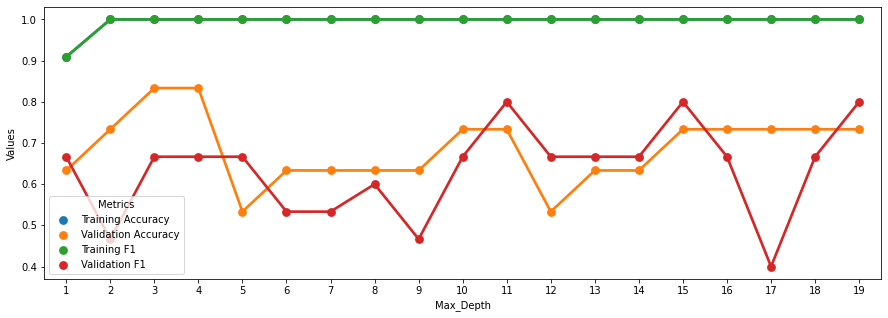

In [254]:
training_accuracy = []
val_accuracy = []
training_f1 = []
val_f1 = []
tree_depths = []

for depth in range(1,20):
    tree_clf = DecisionTreeClassifier(max_depth=depth)
    tree_clf.fit(X_train,y_train)
    y_training_pred = tree_clf.predict(X_train)

    training_acc = accuracy_score(y_train,y_training_pred)
    train_f1 = f1_score(y_train,y_training_pred)
    val_mean_f1 = cross_val_score(tree_clf,X_train,y_train,cv=5,scoring='f1_macro').mean()
    val_mean_accuracy = cross_val_score(tree_clf,X_train,y_train,cv=5,scoring='accuracy').mean()
    
    training_accuracy.append(training_acc)
    val_accuracy.append(val_mean_accuracy)
    training_f1.append(train_f1)
    val_f1.append(val_mean_f1)
    tree_depths.append(depth)
    

Tuning_Max_depth = {"Training Accuracy": training_accuracy, "Validation Accuracy": val_accuracy, "Training F1": training_f1, "Validation F1":val_f1, "Max_Depth": tree_depths }
Tuning_Max_depth_df = pd.DataFrame.from_dict(Tuning_Max_depth)

plot_df = Tuning_Max_depth_df.melt('Max_Depth',var_name='Metrics',value_name="Values")
fig,ax = plt.subplots(figsize=(15,5))
sns.pointplot(x="Max_Depth", y="Values",hue="Metrics", data=plot_df,ax=ax)

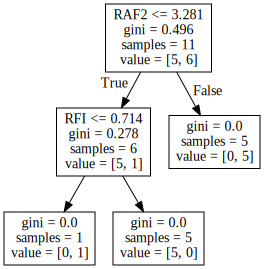

In [255]:
import graphviz 
from sklearn import tree

tree_clf = tree.DecisionTreeClassifier(max_depth = 3)
tree_clf.fit(X_train,y_train)
dot_data = tree.export_graphviz(tree_clf,feature_names = X.columns.tolist())
graph = graphviz.Source(dot_data)
graph

<AxesSubplot:xlabel='Min_Samples_leaf', ylabel='Values'>

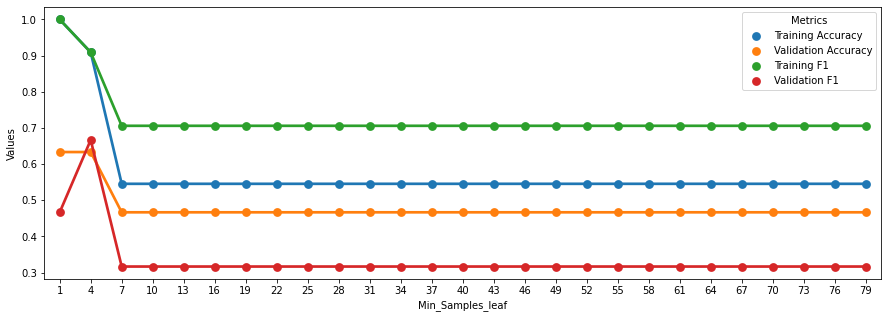

In [256]:
training_accuracy = []
val_accuracy = []
training_f1 = []
val_f1 = []
min_samples_leaf = []
import numpy as np
for samples_leaf in range(1,80,3): ### Sweeping from 1% samples to 10% samples per leaf 
    tree_clf = DecisionTreeClassifier(max_depth=3,min_samples_leaf = samples_leaf)
    tree_clf.fit(X_train,y_train)
    y_training_pred = tree_clf.predict(X_train)

    training_acc = accuracy_score(y_train,y_training_pred)
    train_f1 = f1_score(y_train,y_training_pred)
    val_mean_f1 = cross_val_score(tree_clf,X_train,y_train,cv=5,scoring='f1_macro').mean()
    val_mean_accuracy = cross_val_score(tree_clf,X_train,y_train,cv=5,scoring='accuracy').mean()
    
    training_accuracy.append(training_acc)
    val_accuracy.append(val_mean_accuracy)
    training_f1.append(train_f1)
    val_f1.append(val_mean_f1)
    min_samples_leaf.append(samples_leaf)
    

Tuning_min_samples_leaf = {"Training Accuracy": training_accuracy, "Validation Accuracy": val_accuracy, "Training F1": training_f1, "Validation F1":val_f1, "Min_Samples_leaf": min_samples_leaf }
Tuning_min_samples_leaf_df = pd.DataFrame.from_dict(Tuning_min_samples_leaf)

plot_df = Tuning_min_samples_leaf_df.melt('Min_Samples_leaf',var_name='Metrics',value_name="Values")
fig,ax = plt.subplots(figsize=(15,5))
sns.pointplot(x="Min_Samples_leaf", y="Values",hue="Metrics", data=plot_df,ax=ax)


In [257]:
from sklearn.metrics import confusion_matrix
tree_clf = DecisionTreeClassifier(max_depth=3,min_samples_leaf = 35)
tree_clf.fit(X_train,y_train)
y_pred = tree_clf.predict(X_test)
print("Test Accuracy: ",accuracy_score(y_test,y_pred))
print("Test F1 Score: ",f1_score(y_test,y_pred))
print("Confusion Matrix on Test Data")
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Test Accuracy:  0.45454545454545453
Test F1 Score:  0.625
Confusion Matrix on Test Data


Predicted,1,All
True,,
0,6,6
1,5,5
All,11,11


---CV SCORE--- 0.29166666666666663
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.45      1.00      0.62         5

    accuracy                           0.45        11
   macro avg       0.23      0.50      0.31        11
weighted avg       0.21      0.45      0.28        11



D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


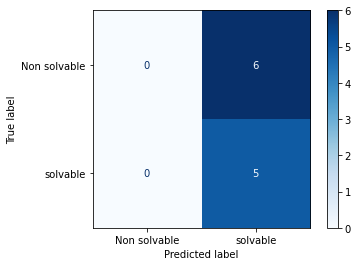

In [258]:
evaluation(tree_clf,X_train,y_train,X_test,y_test)

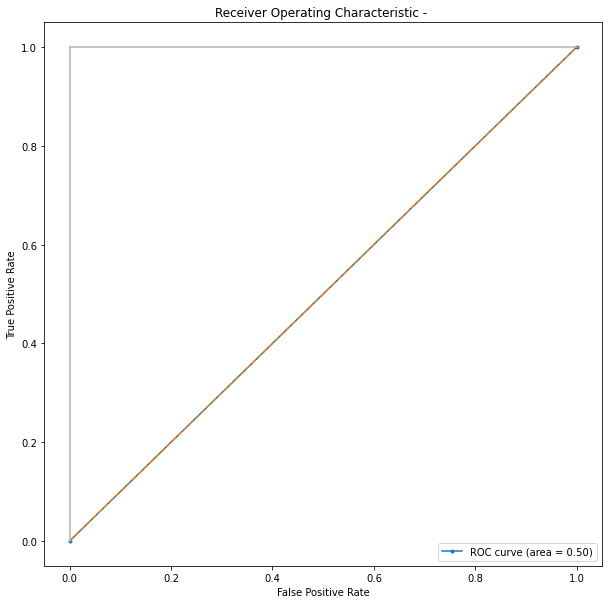

In [259]:
plot_roc(X_test,y_test,tree_clf)

##### Model 2: Random Forest Classifier


In [260]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100,max_depth=3,min_samples_leaf = 10)
rf_clf.fit(X_train,y_train)
y_pred = rf_clf.predict(X_train)
print("Train F1 Score ", f1_score(y_train,y_pred))
print("Train Accuracy ", accuracy_score(y_train,y_pred))

print("Validation Mean F1 Score: ",cross_val_score(rf_clf,X_train,y_train,cv=5,scoring='f1_macro').mean())
print("Validation Mean Accuracy: ",cross_val_score(rf_clf,X_train,y_train,cv=5,scoring='accuracy').mean())

Train F1 Score  0.7058823529411764
Train Accuracy  0.5454545454545454
Validation Mean F1 Score:  0.3166666666666666
Validation Mean Accuracy:  0.5333333333333333


In [261]:
y_pred = rf_clf.predict(X_test)
print("Test Accuracy: ",accuracy_score(y_test,y_pred))
print("Test F1 Score: ",f1_score(y_test,y_pred))
print("Confusion Matrix on Test Data")
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Test Accuracy:  0.45454545454545453
Test F1 Score:  0.625
Confusion Matrix on Test Data


Predicted,1,All
True,,
0,6,6
1,5,5
All,11,11


---CV SCORE--- 0.6916666666666667
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.45      1.00      0.62         5

    accuracy                           0.45        11
   macro avg       0.23      0.50      0.31        11
weighted avg       0.21      0.45      0.28        11



D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


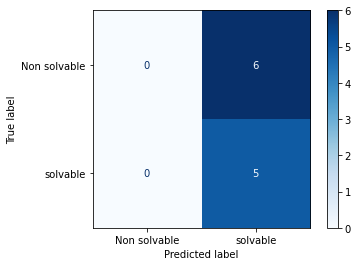

In [262]:
evaluation(rf_clf,X_train,y_train,X_test,y_test)

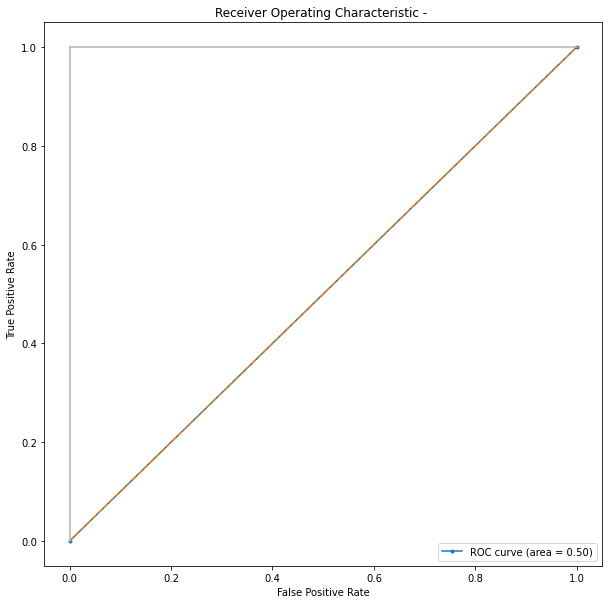

In [263]:
plot_roc(X_test,y_test,rf_clf)

##### Model 3: Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict

train_accuracies = []
train_f1_scores = []
test_accuracies = []
test_f1_scores = []
thresholds = []

#for thresh in np.linspace(0.1,0.9,8): ## Sweeping from threshold of 0.1 to 0.9
for thresh in np.arange(0.1,0.9,0.1): ## Sweeping from threshold of 0.1 to 0.9
    logreg_clf = LogisticRegression(solver='liblinear')
    logreg_clf.fit(X_train,y_train)
    
    y_pred_train_thresh = logreg_clf.predict_proba(X_train)[:,1]
    y_pred_train = (y_pred_train_thresh > thresh).astype(int)

    train_acc = accuracy_score(y_train,y_pred_train)
    train_f1 = f1_score(y_train,y_pred_train)
    
    y_pred_test_thresh = logreg_clf.predict_proba(X_test)[:,1]
    y_pred_test = (y_pred_test_thresh > thresh).astype(int) 
    
    test_acc = accuracy_score(y_test,y_pred_test)
    test_f1 = f1_score(y_test,y_pred_test)
    
    train_accuracies.append(train_acc)
    train_f1_scores.append(train_f1)
    test_accuracies.append(test_acc)
    test_f1_scores.append(test_f1)
    thresholds.append(thresh)
    
    
Threshold_logreg = {"Training Accuracy": train_accuracies, "Test Accuracy": test_accuracies, "Training F1": train_f1_scores, "Test F1":test_f1_scores, "Decision Threshold": thresholds }
Threshold_logreg_df = pd.DataFrame.from_dict(Threshold_logreg)

plot_df = Threshold_logreg_df.melt('Decision Threshold',var_name='Metrics',value_name="Values")
fig,ax = plt.subplots(figsize=(15,5))
sns.pointplot(x="Decision Threshold", y="Values",hue="Metrics", data=plot_df,ax=ax)


In [265]:
thresh = 0.4 ### Threshold chosen from above Curves
y_pred_test_thresh = logreg_clf.predict_proba(X_test)[:,1]
y_pred = (y_pred_test_thresh > thresh).astype(int) 
print("Test Accuracy: ",accuracy_score(y_test,y_pred))
print("Test F1 Score: ",f1_score(y_test,y_pred))
print("Confusion Matrix on Test Data")
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Test Accuracy:  0.45454545454545453
Test F1 Score:  0.625
Confusion Matrix on Test Data


Predicted,1,All
True,,
0,6,6
1,5,5
All,11,11


In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict

In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,f1_score

In [34]:
logreg_clf = LogisticRegression(solver='liblinear')
logreg_clf.fit(X_train,y_train)

LogisticRegression(solver='liblinear')

---CV SCORE--- 0.6916666666666667
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.45      1.00      0.62         5

    accuracy                           0.45        11
   macro avg       0.23      0.50      0.31        11
weighted avg       0.21      0.45      0.28        11



D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


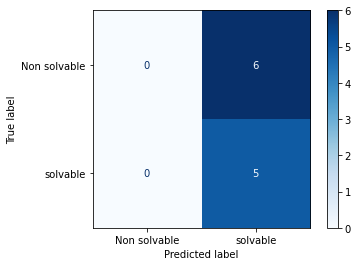

In [35]:
evaluation(logreg_clf,X_train,y_train,X_test,y_test)

In [37]:
import joblib as joblib

In [39]:
filename='final_model.sav'
joblib.dump(logreg_clf,filename)

['final_model.sav']

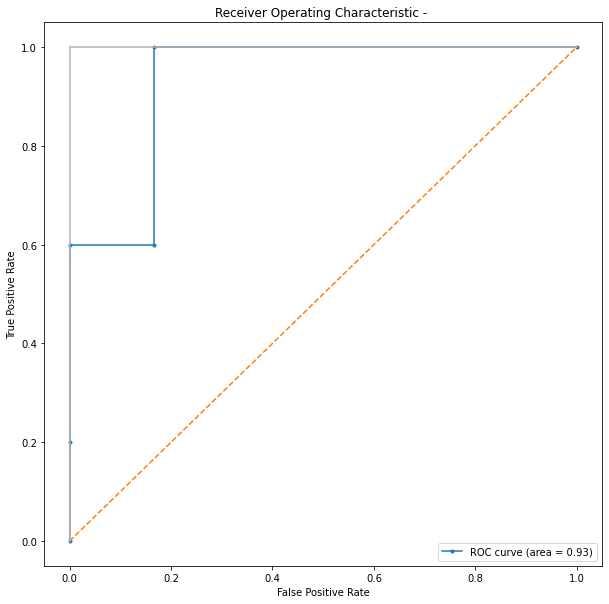

In [267]:
plot_roc(X_test,y_test,logreg_clf)

##### Model 4:knn

Text(0, 0.5, 'Erreur')

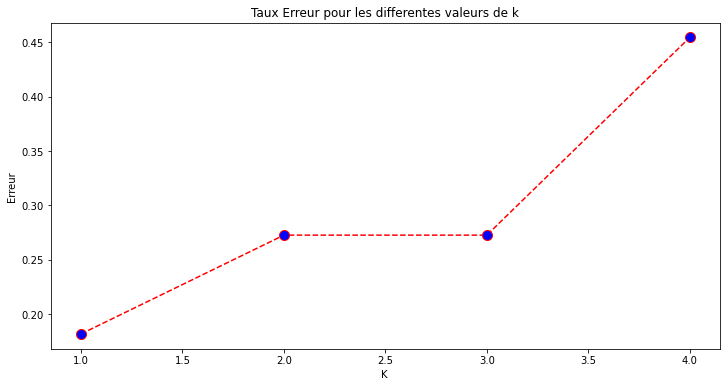

In [270]:
from sklearn.neighbors import KNeighborsClassifier

error = []
# Calculer l'erreur pour k entre 1 et 40 
#Pour chaque itération, l'erreur moyenne pour les valeurs prédites 
#de l'ensemble de test est calculée et sauvegardée ds la liste Erreur.
# Tester k de 1 à 40 et la distance Manhattan
for i in range(1, 5):
    knn = KNeighborsClassifier(i,metric='manhattan')
    knn_model = knn.fit(X_train, y_train)
    pred_i = knn_model.predict(X_test)
    error.append(np.mean(pred_i != y_test))
plt.figure(figsize=(12, 6))
plt.plot(range(1, 5), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Taux Erreur pour les differentes valeurs de k')
plt.xlabel('K ')
plt.ylabel('Erreur')

In [271]:
from sklearn.model_selection import GridSearchCV
leaf_size = list(range(1,20))# Par défaut c'est 30
n_neighbors = list(range(1,5))
p=[1,2] #p = 1 manhattan_distance/p=2 euclidean_distance
#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
#Create new KNN object
knn_2 = KNeighborsClassifier()
#Use GridSearch
clf = GridSearchCV(knn_2, hyperparameters, cv=2, n_jobs=-1)
#n_jobs: number of CPU'sfor execution.
#cv: number of folds of the cross validation

#Fit the model
best_model = clf.fit(X_train, y_train)
#Print The value of best Hyperparameters
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

Best leaf_size: 1
Best p: 1
Best n_neighbors: 2


In [272]:
best_model.best_estimator_.fit(X_train, y_train)

KNeighborsClassifier(leaf_size=1, n_neighbors=2, p=1)

---CV SCORE--- 0.16666666666666666
              precision    recall  f1-score   support

           0       0.56      0.83      0.67         6
           1       0.50      0.20      0.29         5

    accuracy                           0.55        11
   macro avg       0.53      0.52      0.48        11
weighted avg       0.53      0.55      0.49        11



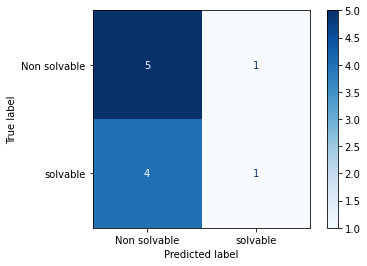

In [273]:
evaluation(knn,X_train,y_train,X_test,y_test)

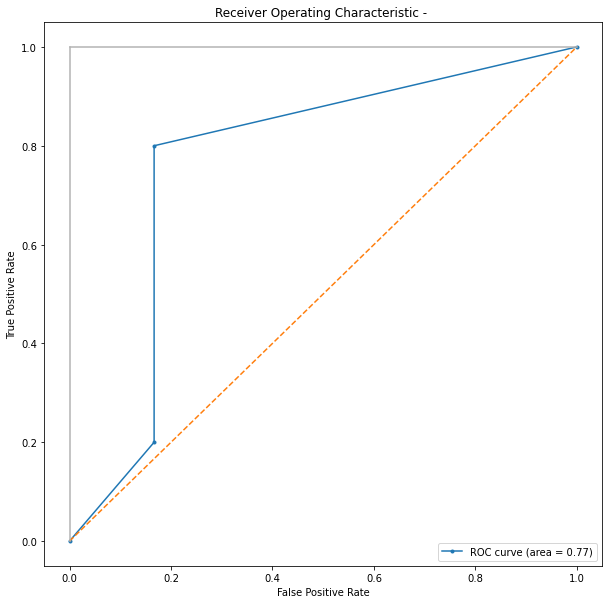

In [274]:
plot_roc(X_test,y_test,knn)

### KNeighborsRegressor

In [275]:
########## Split Features and Target Varible ############
columns=['Unnamed: 0','total des actifs', 'total des actifs courant',
       'liquidités', 'stocks', 'clients Et comptes Rattachés',
       'capitaux propres', 'total des passifs courants',
       'total des passifs non courants', 'fournisseurs et comptes rattachés',
       'résultat net', 'total des produits exploitation',
       'achats de marchandises',
       'dotations aux amortissements et aux provisions',
       'charges financières nettes', 'resultat exploitation',
       'total des flux de trésorerie liés aux opérations exploitation',
       'total des actifs non courant', 'Fonds de roulement',
       'charges exploitation', 'EBIT', 'total des passifs', 'A', 'B', 'C', 'D',
       'E', 'scoring', 'Approval']
X = Final_Sampled_Data_KNeighborsRegressor.drop(columns, axis=1)

    
y = Final_Sampled_Data_KNeighborsRegressor['Approval']

################# Splitting into Train -Test Data #######
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.5,stratify =y,random_state =42)


##### Model 1: Decision Tree Classifier

In [276]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,f1_score


tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train,y_train)
y_pred = tree_clf.predict(X_train)
print("Training Data Set Accuracy: ", accuracy_score(y_train,y_pred))
print("Training Data F1 Score ", f1_score(y_train,y_pred))

print("Validation Mean F1 Score: ",cross_val_score(tree_clf,X_train,y_train,cv=5,scoring='f1_macro').mean())
print("Validation Mean Accuracy: ",cross_val_score(tree_clf,X_train,y_train,cv=5,scoring='accuracy').mean())

Training Data Set Accuracy:  1.0
Training Data F1 Score  1.0
Validation Mean F1 Score:  0.2
Validation Mean Accuracy:  0.3


In [277]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='Max_Depth', ylabel='Values'>

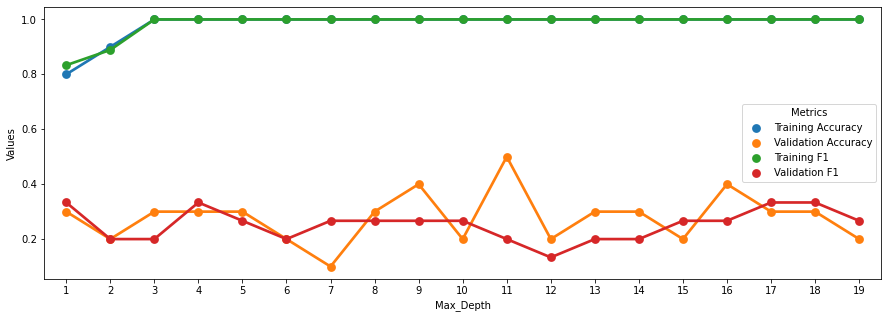

In [278]:
training_accuracy = []
val_accuracy = []
training_f1 = []
val_f1 = []
tree_depths = []

for depth in range(1,20):
    tree_clf = DecisionTreeClassifier(max_depth=depth)
    tree_clf.fit(X_train,y_train)
    y_training_pred = tree_clf.predict(X_train)

    training_acc = accuracy_score(y_train,y_training_pred)
    train_f1 = f1_score(y_train,y_training_pred)
    val_mean_f1 = cross_val_score(tree_clf,X_train,y_train,cv=5,scoring='f1_macro').mean()
    val_mean_accuracy = cross_val_score(tree_clf,X_train,y_train,cv=5,scoring='accuracy').mean()
    
    training_accuracy.append(training_acc)
    val_accuracy.append(val_mean_accuracy)
    training_f1.append(train_f1)
    val_f1.append(val_mean_f1)
    tree_depths.append(depth)
    

Tuning_Max_depth = {"Training Accuracy": training_accuracy, "Validation Accuracy": val_accuracy, "Training F1": training_f1, "Validation F1":val_f1, "Max_Depth": tree_depths }
Tuning_Max_depth_df = pd.DataFrame.from_dict(Tuning_Max_depth)

plot_df = Tuning_Max_depth_df.melt('Max_Depth',var_name='Metrics',value_name="Values")
fig,ax = plt.subplots(figsize=(15,5))
sns.pointplot(x="Max_Depth", y="Values",hue="Metrics", data=plot_df,ax=ax)

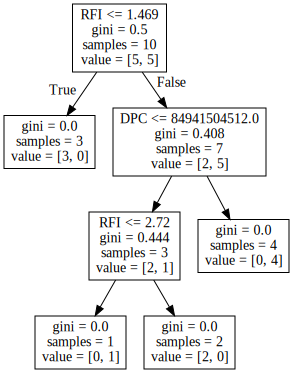

In [279]:
import graphviz 
from sklearn import tree

tree_clf = tree.DecisionTreeClassifier(max_depth = 3)
tree_clf.fit(X_train,y_train)
dot_data = tree.export_graphviz(tree_clf,feature_names = X.columns.tolist())
graph = graphviz.Source(dot_data)
graph

<AxesSubplot:xlabel='Min_Samples_leaf', ylabel='Values'>

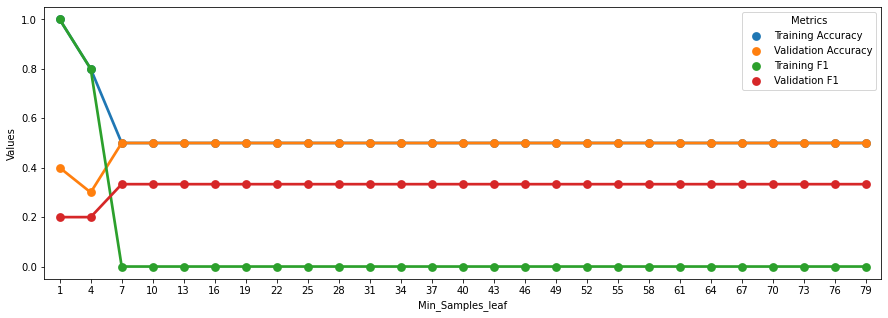

In [280]:
training_accuracy = []
val_accuracy = []
training_f1 = []
val_f1 = []
min_samples_leaf = []
import numpy as np
for samples_leaf in range(1,80,3): ### Sweeping from 1% samples to 10% samples per leaf 
    tree_clf = DecisionTreeClassifier(max_depth=3,min_samples_leaf = samples_leaf)
    tree_clf.fit(X_train,y_train)
    y_training_pred = tree_clf.predict(X_train)

    training_acc = accuracy_score(y_train,y_training_pred)
    train_f1 = f1_score(y_train,y_training_pred)
    val_mean_f1 = cross_val_score(tree_clf,X_train,y_train,cv=5,scoring='f1_macro').mean()
    val_mean_accuracy = cross_val_score(tree_clf,X_train,y_train,cv=5,scoring='accuracy').mean()
    
    training_accuracy.append(training_acc)
    val_accuracy.append(val_mean_accuracy)
    training_f1.append(train_f1)
    val_f1.append(val_mean_f1)
    min_samples_leaf.append(samples_leaf)
    

Tuning_min_samples_leaf = {"Training Accuracy": training_accuracy, "Validation Accuracy": val_accuracy, "Training F1": training_f1, "Validation F1":val_f1, "Min_Samples_leaf": min_samples_leaf }
Tuning_min_samples_leaf_df = pd.DataFrame.from_dict(Tuning_min_samples_leaf)

plot_df = Tuning_min_samples_leaf_df.melt('Min_Samples_leaf',var_name='Metrics',value_name="Values")
fig,ax = plt.subplots(figsize=(15,5))
sns.pointplot(x="Min_Samples_leaf", y="Values",hue="Metrics", data=plot_df,ax=ax)


In [281]:
from sklearn.metrics import confusion_matrix
tree_clf = DecisionTreeClassifier(max_depth=3,min_samples_leaf = 35)
tree_clf.fit(X_train,y_train)
y_pred = tree_clf.predict(X_test)
print("Test Accuracy: ",accuracy_score(y_test,y_pred))
print("Test F1 Score: ",f1_score(y_test,y_pred))
print("Confusion Matrix on Test Data")
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Test Accuracy:  0.6
Test F1 Score:  0.0
Confusion Matrix on Test Data


Predicted,0,All
True,,
0,6,6
1,4,4
All,10,10


---CV SCORE--- 0.125
              precision    recall  f1-score   support

           0       0.60      1.00      0.75         6
           1       0.00      0.00      0.00         4

    accuracy                           0.60        10
   macro avg       0.30      0.50      0.37        10
weighted avg       0.36      0.60      0.45        10



D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


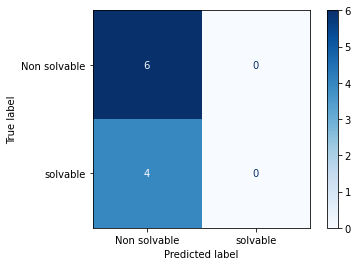

In [282]:
evaluation(tree_clf,X_train,y_train,X_test,y_test)

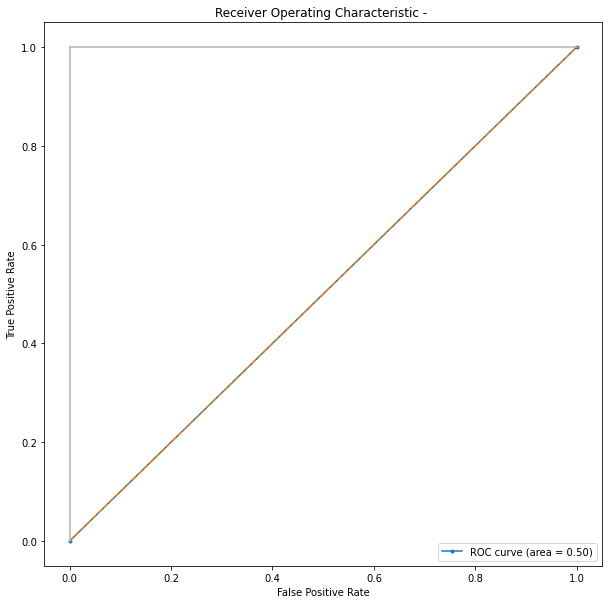

In [283]:
plot_roc(X_test,y_test,tree_clf)

##### Model 2: Random Forest Classifier

In [284]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100,max_depth=3,min_samples_leaf = 10)
rf_clf.fit(X_train,y_train)
y_pred = rf_clf.predict(X_train)
print("Train F1 Score ", f1_score(y_train,y_pred))
print("Train Accuracy ", accuracy_score(y_train,y_pred))

print("Validation Mean F1 Score: ",cross_val_score(rf_clf,X_train,y_train,cv=5,scoring='f1_macro').mean())
print("Validation Mean Accuracy: ",cross_val_score(rf_clf,X_train,y_train,cv=5,scoring='accuracy').mean())

Train F1 Score  0.6666666666666666
Train Accuracy  0.5
Validation Mean F1 Score:  0.3333333333333333
Validation Mean Accuracy:  0.5


In [285]:
y_pred = rf_clf.predict(X_test)
print("Test Accuracy: ",accuracy_score(y_test,y_pred))
print("Test F1 Score: ",f1_score(y_test,y_pred))
print("Confusion Matrix on Test Data")
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Test Accuracy:  0.4
Test F1 Score:  0.5714285714285715
Confusion Matrix on Test Data


Predicted,1,All
True,,
0,6,6
1,4,4
All,10,10


---CV SCORE--- 0.29166666666666663
              precision    recall  f1-score   support

           0       0.60      1.00      0.75         6
           1       0.00      0.00      0.00         4

    accuracy                           0.60        10
   macro avg       0.30      0.50      0.37        10
weighted avg       0.36      0.60      0.45        10



D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


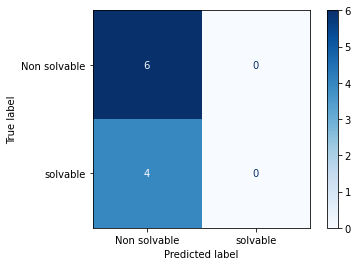

In [286]:
evaluation(rf_clf,X_train,y_train,X_test,y_test)

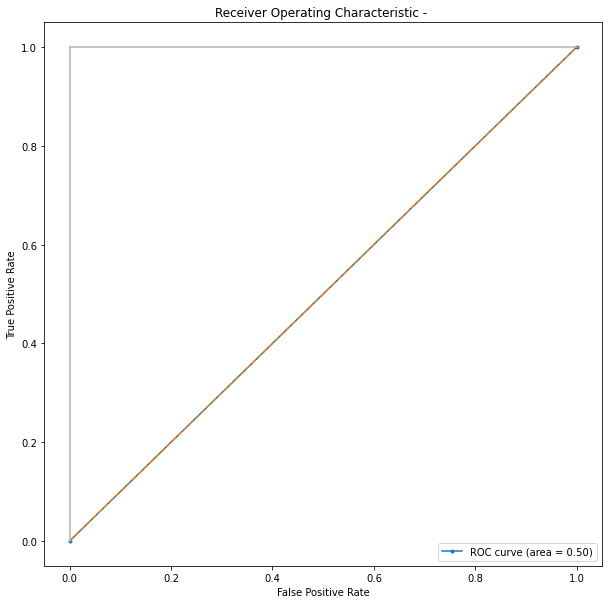

In [287]:
plot_roc(X_test,y_test,rf_clf)

##### Model 3: Logistic Regression

<AxesSubplot:xlabel='Decision Threshold', ylabel='Values'>

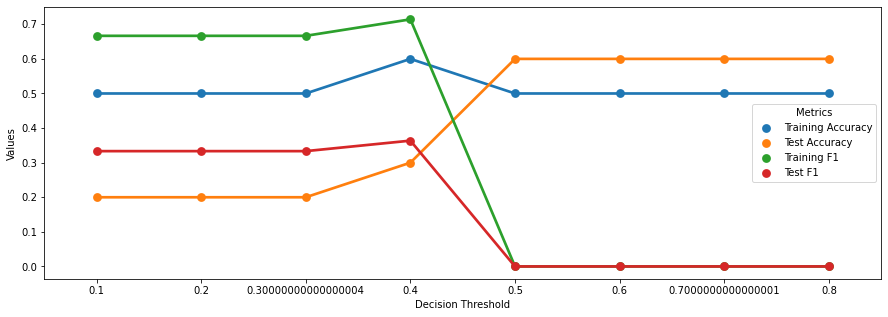

In [288]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict

train_accuracies = []
train_f1_scores = []
test_accuracies = []
test_f1_scores = []
thresholds = []

#for thresh in np.linspace(0.1,0.9,8): ## Sweeping from threshold of 0.1 to 0.9
for thresh in np.arange(0.1,0.9,0.1): ## Sweeping from threshold of 0.1 to 0.9
    logreg_clf = LogisticRegression(solver='liblinear')
    logreg_clf.fit(X_train,y_train)
    
    y_pred_train_thresh = logreg_clf.predict_proba(X_train)[:,1]
    y_pred_train = (y_pred_train_thresh > thresh).astype(int)

    train_acc = accuracy_score(y_train,y_pred_train)
    train_f1 = f1_score(y_train,y_pred_train)
    
    y_pred_test_thresh = logreg_clf.predict_proba(X_test)[:,1]
    y_pred_test = (y_pred_test_thresh > thresh).astype(int) 
    
    test_acc = accuracy_score(y_test,y_pred_test)
    test_f1 = f1_score(y_test,y_pred_test)
    
    train_accuracies.append(train_acc)
    train_f1_scores.append(train_f1)
    test_accuracies.append(test_acc)
    test_f1_scores.append(test_f1)
    thresholds.append(thresh)
    
    
Threshold_logreg = {"Training Accuracy": train_accuracies, "Test Accuracy": test_accuracies, "Training F1": train_f1_scores, "Test F1":test_f1_scores, "Decision Threshold": thresholds }
Threshold_logreg_df = pd.DataFrame.from_dict(Threshold_logreg)

plot_df = Threshold_logreg_df.melt('Decision Threshold',var_name='Metrics',value_name="Values")
fig,ax = plt.subplots(figsize=(15,5))
sns.pointplot(x="Decision Threshold", y="Values",hue="Metrics", data=plot_df,ax=ax)


In [289]:
thresh = 0.4 ### Threshold chosen from above Curves
y_pred_test_thresh = logreg_clf.predict_proba(X_test)[:,1]
y_pred = (y_pred_test_thresh > thresh).astype(int) 
print("Test Accuracy: ",accuracy_score(y_test,y_pred))
print("Test F1 Score: ",f1_score(y_test,y_pred))
print("Confusion Matrix on Test Data")
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Test Accuracy:  0.3
Test F1 Score:  0.36363636363636365
Confusion Matrix on Test Data


Predicted,0,1,All
True,,,
0,1,5,6
1,2,2,4
All,3,7,10


---CV SCORE--- 0.16666666666666666
              precision    recall  f1-score   support

           0       0.60      1.00      0.75         6
           1       0.00      0.00      0.00         4

    accuracy                           0.60        10
   macro avg       0.30      0.50      0.37        10
weighted avg       0.36      0.60      0.45        10



D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


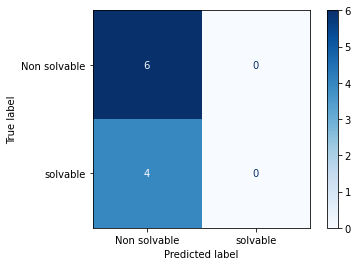

In [290]:
evaluation(logreg_clf,X_train,y_train,X_test,y_test)

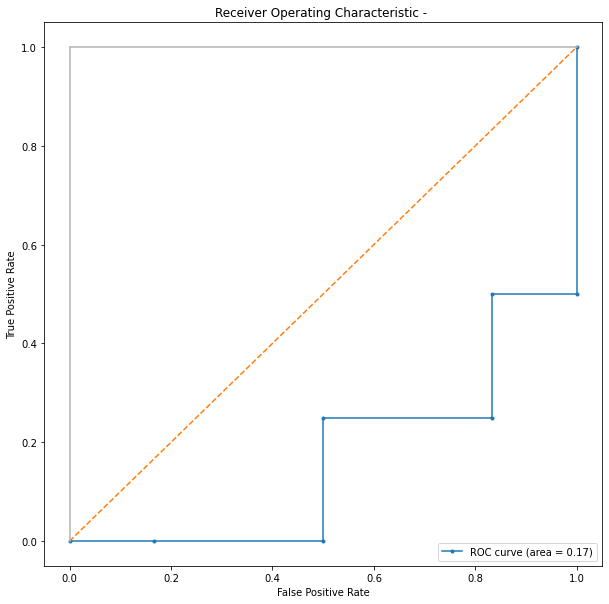

In [291]:
plot_roc(X_test,y_test,logreg_clf)

##### Model 4:knn

Text(0, 0.5, 'Erreur')

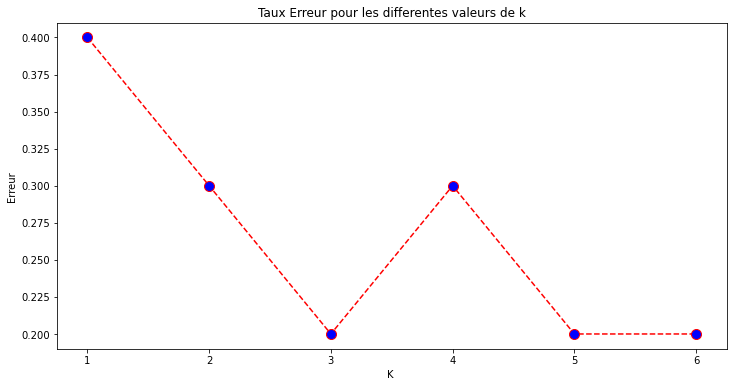

In [302]:
from sklearn.neighbors import KNeighborsClassifier

error = []
# Calculer l'erreur pour k entre 1 et 40 
#Pour chaque itération, l'erreur moyenne pour les valeurs prédites 
#de l'ensemble de test est calculée et sauvegardée ds la liste Erreur.
# Tester k de 1 à 40 et la distance Manhattan
for i in range(1, 7):
    knn = KNeighborsClassifier(i,metric='manhattan')
    knn_model = knn.fit(X_train, y_train)
    pred_i = knn_model.predict(X_test)
    error.append(np.mean(pred_i != y_test))
plt.figure(figsize=(12, 6))
plt.plot(range(1, 7), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Taux Erreur pour les differentes valeurs de k')
plt.xlabel('K ')
plt.ylabel('Erreur')

In [303]:
from sklearn.model_selection import GridSearchCV
leaf_size = list(range(1,20))# Par défaut c'est 30
n_neighbors = list(range(1,5))
p=[1,2] #p = 1 manhattan_distance/p=2 euclidean_distance
#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
#Create new KNN object
knn_2 = KNeighborsClassifier()
#Use GridSearch
clf = GridSearchCV(knn_2, hyperparameters, cv=2, n_jobs=-1)
#n_jobs: number of CPU'sfor execution.
#cv: number of folds of the cross validation

#Fit the model
best_model = clf.fit(X_train, y_train)
#Print The value of best Hyperparameters
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

Best leaf_size: 1
Best p: 1
Best n_neighbors: 1


In [304]:
best_model.best_estimator_.fit(X_train, y_train)

KNeighborsClassifier(leaf_size=1, n_neighbors=1, p=1)

---CV SCORE--- 0.45833333333333326
              precision    recall  f1-score   support

           0       0.83      0.83      0.83         6
           1       0.75      0.75      0.75         4

    accuracy                           0.80        10
   macro avg       0.79      0.79      0.79        10
weighted avg       0.80      0.80      0.80        10



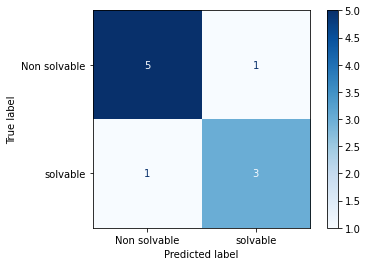

In [305]:
evaluation(knn,X_train,y_train,X_test,y_test)

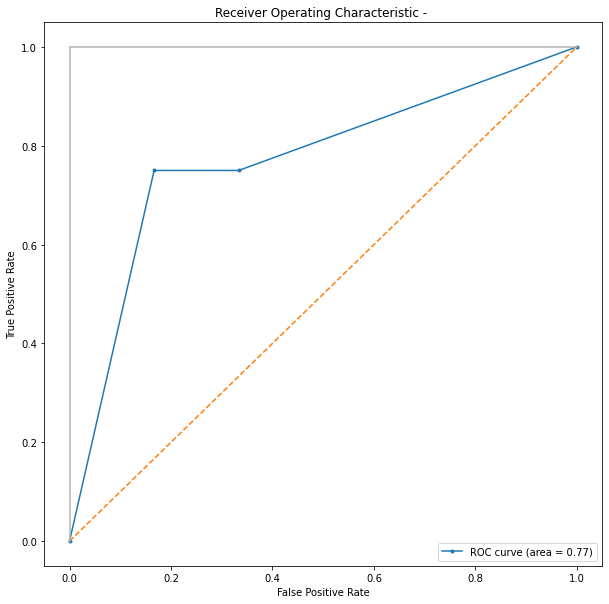

In [306]:
plot_roc(X_test,y_test,knn)

### ExtraTreesRegressor

In [307]:
########## Split Features and Target Varible ############
columns=['Unnamed: 0','total des actifs', 'total des actifs courant',
       'liquidités', 'stocks', 'clients Et comptes Rattachés',
       'capitaux propres', 'total des passifs courants',
       'total des passifs non courants', 'fournisseurs et comptes rattachés',
       'résultat net', 'total des produits exploitation',
       'achats de marchandises',
       'dotations aux amortissements et aux provisions',
       'charges financières nettes', 'resultat exploitation',
       'total des flux de trésorerie liés aux opérations exploitation',
       'total des actifs non courant', 'Fonds de roulement',
       'charges exploitation', 'EBIT', 'total des passifs', 'A', 'B', 'C', 'D',
       'E', 'scoring', 'Approval']
X = Final_Sampled_Data_ExtraTreesRegressor.drop(columns, axis=1)

    
y = Final_Sampled_Data_ExtraTreesRegressor['Approval']

################# Splitting into Train -Test Data #######
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.5,stratify =y,random_state =42)


##### Model 1: Decision Tree Classifier

In [308]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,f1_score


tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train,y_train)
y_pred = tree_clf.predict(X_train)
print("Training Data Set Accuracy: ", accuracy_score(y_train,y_pred))
print("Training Data F1 Score ", f1_score(y_train,y_pred))

print("Validation Mean F1 Score: ",cross_val_score(tree_clf,X_train,y_train,cv=5,scoring='f1_macro').mean())
print("Validation Mean Accuracy: ",cross_val_score(tree_clf,X_train,y_train,cv=5,scoring='accuracy').mean())

Training Data Set Accuracy:  1.0
Training Data F1 Score  1.0
Validation Mean F1 Score:  0.5333333333333333
Validation Mean Accuracy:  0.6


D:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
D:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


In [309]:
import seaborn as sns
import matplotlib.pyplot as plt

D:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
D:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
D:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
D:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
D:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least

<AxesSubplot:xlabel='Max_Depth', ylabel='Values'>

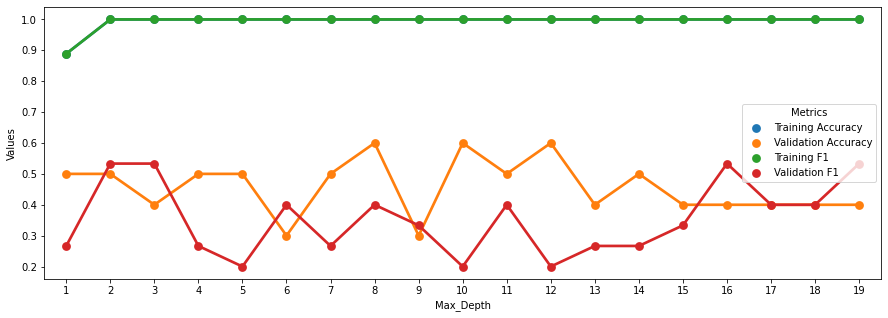

In [310]:
training_accuracy = []
val_accuracy = []
training_f1 = []
val_f1 = []
tree_depths = []

for depth in range(1,20):
    tree_clf = DecisionTreeClassifier(max_depth=depth)
    tree_clf.fit(X_train,y_train)
    y_training_pred = tree_clf.predict(X_train)

    training_acc = accuracy_score(y_train,y_training_pred)
    train_f1 = f1_score(y_train,y_training_pred)
    val_mean_f1 = cross_val_score(tree_clf,X_train,y_train,cv=5,scoring='f1_macro').mean()
    val_mean_accuracy = cross_val_score(tree_clf,X_train,y_train,cv=5,scoring='accuracy').mean()
    
    training_accuracy.append(training_acc)
    val_accuracy.append(val_mean_accuracy)
    training_f1.append(train_f1)
    val_f1.append(val_mean_f1)
    tree_depths.append(depth)
    

Tuning_Max_depth = {"Training Accuracy": training_accuracy, "Validation Accuracy": val_accuracy, "Training F1": training_f1, "Validation F1":val_f1, "Max_Depth": tree_depths }
Tuning_Max_depth_df = pd.DataFrame.from_dict(Tuning_Max_depth)

plot_df = Tuning_Max_depth_df.melt('Max_Depth',var_name='Metrics',value_name="Values")
fig,ax = plt.subplots(figsize=(15,5))
sns.pointplot(x="Max_Depth", y="Values",hue="Metrics", data=plot_df,ax=ax)

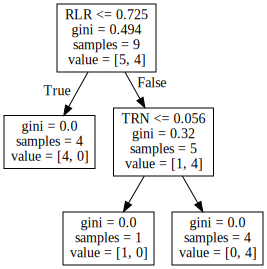

In [311]:
import graphviz 
from sklearn import tree

tree_clf = tree.DecisionTreeClassifier(max_depth = 3)
tree_clf.fit(X_train,y_train)
dot_data = tree.export_graphviz(tree_clf,feature_names = X.columns.tolist())
graph = graphviz.Source(dot_data)
graph

D:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
D:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
D:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
D:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
D:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least

D:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
D:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
D:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
D:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
D:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least

<AxesSubplot:xlabel='Min_Samples_leaf', ylabel='Values'>

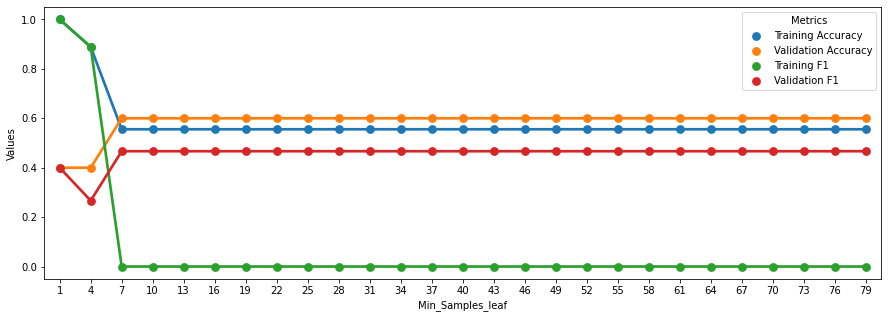

In [312]:
training_accuracy = []
val_accuracy = []
training_f1 = []
val_f1 = []
min_samples_leaf = []
import numpy as np
for samples_leaf in range(1,80,3): ### Sweeping from 1% samples to 10% samples per leaf 
    tree_clf = DecisionTreeClassifier(max_depth=3,min_samples_leaf = samples_leaf)
    tree_clf.fit(X_train,y_train)
    y_training_pred = tree_clf.predict(X_train)

    training_acc = accuracy_score(y_train,y_training_pred)
    train_f1 = f1_score(y_train,y_training_pred)
    val_mean_f1 = cross_val_score(tree_clf,X_train,y_train,cv=5,scoring='f1_macro').mean()
    val_mean_accuracy = cross_val_score(tree_clf,X_train,y_train,cv=5,scoring='accuracy').mean()
    
    training_accuracy.append(training_acc)
    val_accuracy.append(val_mean_accuracy)
    training_f1.append(train_f1)
    val_f1.append(val_mean_f1)
    min_samples_leaf.append(samples_leaf)
    

Tuning_min_samples_leaf = {"Training Accuracy": training_accuracy, "Validation Accuracy": val_accuracy, "Training F1": training_f1, "Validation F1":val_f1, "Min_Samples_leaf": min_samples_leaf }
Tuning_min_samples_leaf_df = pd.DataFrame.from_dict(Tuning_min_samples_leaf)

plot_df = Tuning_min_samples_leaf_df.melt('Min_Samples_leaf',var_name='Metrics',value_name="Values")
fig,ax = plt.subplots(figsize=(15,5))
sns.pointplot(x="Min_Samples_leaf", y="Values",hue="Metrics", data=plot_df,ax=ax)


In [313]:
from sklearn.metrics import confusion_matrix
tree_clf = DecisionTreeClassifier(max_depth=3,min_samples_leaf = 35)
tree_clf.fit(X_train,y_train)
y_pred = tree_clf.predict(X_test)
print("Test Accuracy: ",accuracy_score(y_test,y_pred))
print("Test F1 Score: ",f1_score(y_test,y_pred))
print("Confusion Matrix on Test Data")
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Test Accuracy:  0.6666666666666666
Test F1 Score:  0.0
Confusion Matrix on Test Data


Predicted,0,All
True,,
0,6,6
1,3,3
All,9,9


---CV SCORE--- 0.0
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         6
           1       0.00      0.00      0.00         3

    accuracy                           0.67         9
   macro avg       0.33      0.50      0.40         9
weighted avg       0.44      0.67      0.53         9



D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


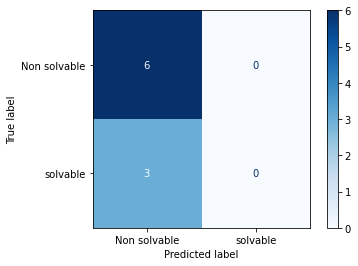

In [314]:
evaluation(tree_clf,X_train,y_train,X_test,y_test)

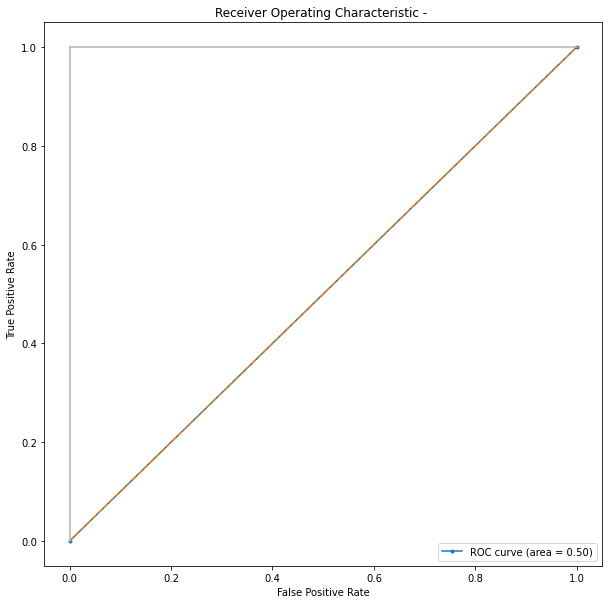

In [315]:
plot_roc(X_test,y_test,tree_clf)

##### Model 2: Random Forest Classifier

In [316]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100,max_depth=3,min_samples_leaf = 10)
rf_clf.fit(X_train,y_train)
y_pred = rf_clf.predict(X_train)
print("Train F1 Score ", f1_score(y_train,y_pred))
print("Train Accuracy ", accuracy_score(y_train,y_pred))

print("Validation Mean F1 Score: ",cross_val_score(rf_clf,X_train,y_train,cv=5,scoring='f1_macro').mean())
print("Validation Mean Accuracy: ",cross_val_score(rf_clf,X_train,y_train,cv=5,scoring='accuracy').mean())

Train F1 Score  0.0
Train Accuracy  0.5555555555555556


D:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Validation Mean F1 Score:  0.4666666666666666


D:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Validation Mean Accuracy:  0.4


In [317]:
y_pred = rf_clf.predict(X_test)
print("Test Accuracy: ",accuracy_score(y_test,y_pred))
print("Test F1 Score: ",f1_score(y_test,y_pred))
print("Confusion Matrix on Test Data")
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Test Accuracy:  0.6666666666666666
Test F1 Score:  0.0
Confusion Matrix on Test Data


Predicted,0,All
True,,
0,6,6
1,3,3
All,9,9


---CV SCORE--- 0.125
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         6
           1       0.00      0.00      0.00         3

    accuracy                           0.67         9
   macro avg       0.33      0.50      0.40         9
weighted avg       0.44      0.67      0.53         9



D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


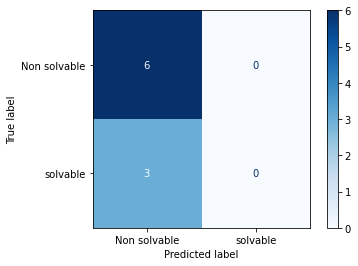

In [318]:
evaluation(rf_clf,X_train,y_train,X_test,y_test)

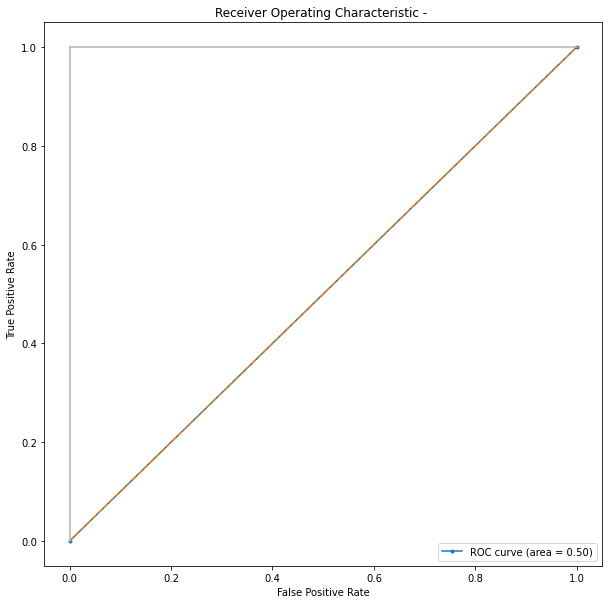

In [319]:
plot_roc(X_test,y_test,rf_clf)

##### Model 3: Logistic Regression

<AxesSubplot:xlabel='Decision Threshold', ylabel='Values'>

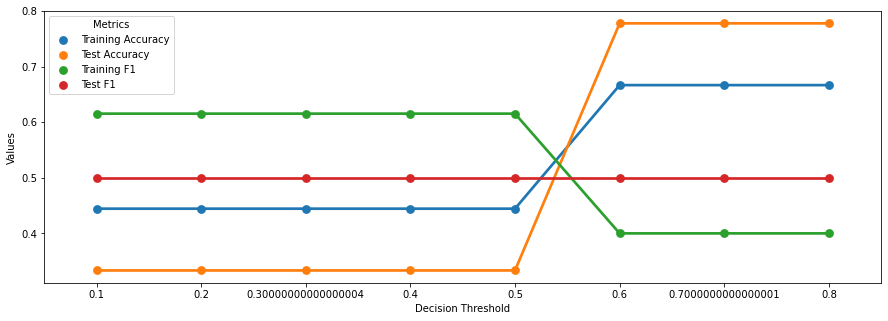

In [320]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict

train_accuracies = []
train_f1_scores = []
test_accuracies = []
test_f1_scores = []
thresholds = []

#for thresh in np.linspace(0.1,0.9,8): ## Sweeping from threshold of 0.1 to 0.9
for thresh in np.arange(0.1,0.9,0.1): ## Sweeping from threshold of 0.1 to 0.9
    logreg_clf = LogisticRegression(solver='liblinear')
    logreg_clf.fit(X_train,y_train)
    
    y_pred_train_thresh = logreg_clf.predict_proba(X_train)[:,1]
    y_pred_train = (y_pred_train_thresh > thresh).astype(int)

    train_acc = accuracy_score(y_train,y_pred_train)
    train_f1 = f1_score(y_train,y_pred_train)
    
    y_pred_test_thresh = logreg_clf.predict_proba(X_test)[:,1]
    y_pred_test = (y_pred_test_thresh > thresh).astype(int) 
    
    test_acc = accuracy_score(y_test,y_pred_test)
    test_f1 = f1_score(y_test,y_pred_test)
    
    train_accuracies.append(train_acc)
    train_f1_scores.append(train_f1)
    test_accuracies.append(test_acc)
    test_f1_scores.append(test_f1)
    thresholds.append(thresh)
    
    
Threshold_logreg = {"Training Accuracy": train_accuracies, "Test Accuracy": test_accuracies, "Training F1": train_f1_scores, "Test F1":test_f1_scores, "Decision Threshold": thresholds }
Threshold_logreg_df = pd.DataFrame.from_dict(Threshold_logreg)

plot_df = Threshold_logreg_df.melt('Decision Threshold',var_name='Metrics',value_name="Values")
fig,ax = plt.subplots(figsize=(15,5))
sns.pointplot(x="Decision Threshold", y="Values",hue="Metrics", data=plot_df,ax=ax)


In [321]:
thresh = 0.4 ### Threshold chosen from above Curves
y_pred_test_thresh = logreg_clf.predict_proba(X_test)[:,1]
y_pred = (y_pred_test_thresh > thresh).astype(int) 
print("Test Accuracy: ",accuracy_score(y_test,y_pred))
print("Test F1 Score: ",f1_score(y_test,y_pred))
print("Confusion Matrix on Test Data")
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Test Accuracy:  0.3333333333333333
Test F1 Score:  0.5
Confusion Matrix on Test Data


Predicted,1,All
True,,
0,6,6
1,3,3
All,9,9


---CV SCORE--- 0.45833333333333326
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.33      1.00      0.50         3

    accuracy                           0.33         9
   macro avg       0.17      0.50      0.25         9
weighted avg       0.11      0.33      0.17         9



D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


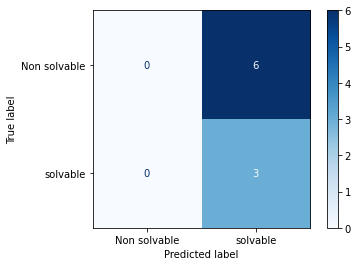

In [322]:
evaluation(logreg_clf,X_train,y_train,X_test,y_test)

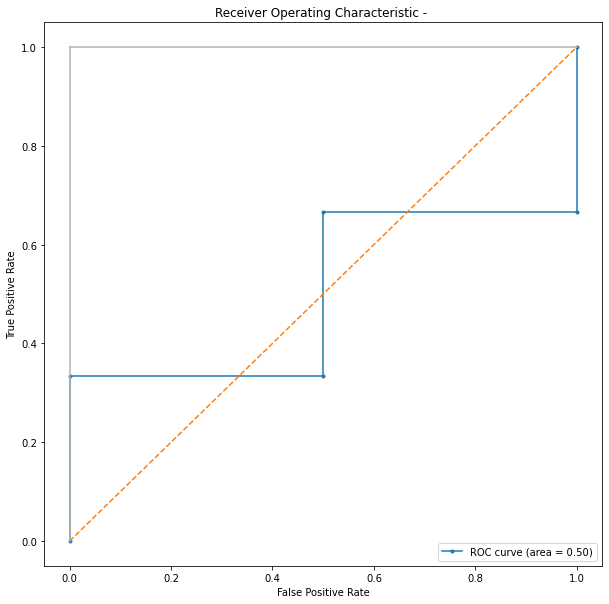

In [323]:
plot_roc(X_test,y_test,logreg_clf)

##### Model 4:knn

Text(0, 0.5, 'Erreur')

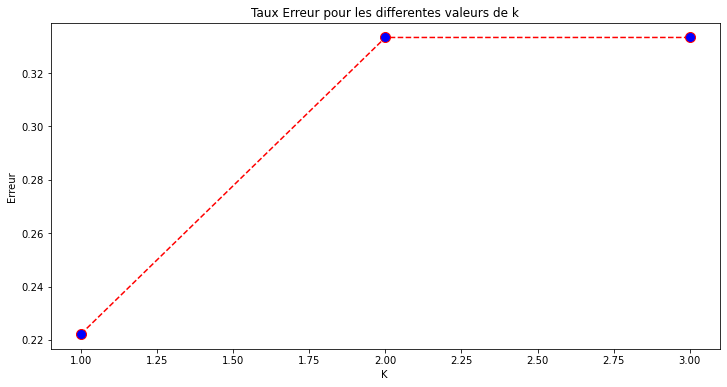

In [326]:
from sklearn.neighbors import KNeighborsClassifier

error = []
# Calculer l'erreur pour k entre 1 et 40 
#Pour chaque itération, l'erreur moyenne pour les valeurs prédites 
#de l'ensemble de test est calculée et sauvegardée ds la liste Erreur.
# Tester k de 1 à 40 et la distance Manhattan
for i in range(1, 4):
    knn = KNeighborsClassifier(i,metric='manhattan')
    knn_model = knn.fit(X_train, y_train)
    pred_i = knn_model.predict(X_test)
    error.append(np.mean(pred_i != y_test))
plt.figure(figsize=(12, 6))
plt.plot(range(1, 4), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Taux Erreur pour les differentes valeurs de k')
plt.xlabel('K ')
plt.ylabel('Erreur')

In [328]:
from sklearn.model_selection import GridSearchCV
leaf_size = list(range(1,20))# Par défaut c'est 30
n_neighbors = list(range(1,4))
p=[1,2] #p = 1 manhattan_distance/p=2 euclidean_distance
#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
#Create new KNN object
knn_2 = KNeighborsClassifier()
#Use GridSearch
clf = GridSearchCV(knn_2, hyperparameters, cv=2, n_jobs=-1)
#n_jobs: number of CPU'sfor execution.
#cv: number of folds of the cross validation

#Fit the model
best_model = clf.fit(X_train, y_train)
#Print The value of best Hyperparameters
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

Best leaf_size: 1
Best p: 1
Best n_neighbors: 3


In [329]:
best_model.best_estimator_.fit(X_train, y_train)

KNeighborsClassifier(leaf_size=1, n_neighbors=3, p=1)

---CV SCORE--- 0.45833333333333326
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         6
           1       0.00      0.00      0.00         3

    accuracy                           0.67         9
   macro avg       0.33      0.50      0.40         9
weighted avg       0.44      0.67      0.53         9



D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


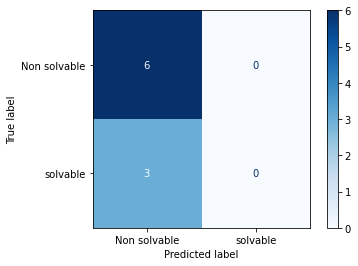

In [330]:
evaluation(knn,X_train,y_train,X_test,y_test)

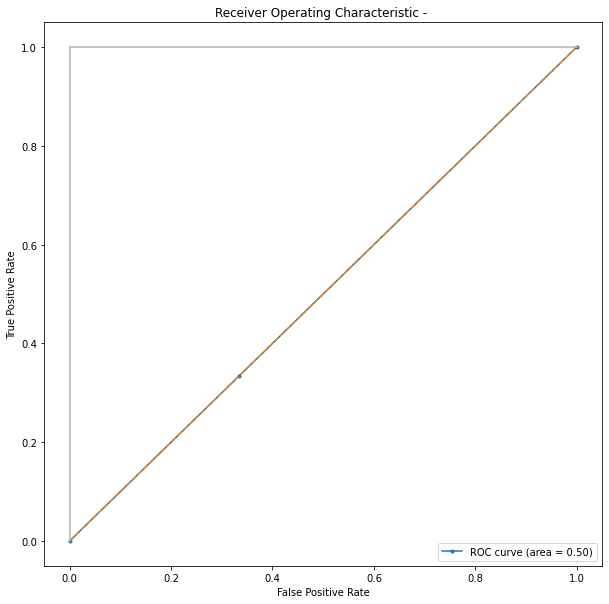

In [331]:
plot_roc(X_test,y_test,knn)

### DecisionTreeRegressor

In [361]:
########## Split Features and Target Varible ############
columns=['Unnamed: 0','total des actifs', 'total des actifs courant',
       'liquidités', 'stocks', 'clients Et comptes Rattachés',
       'capitaux propres', 'total des passifs courants',
       'total des passifs non courants', 'fournisseurs et comptes rattachés',
       'résultat net', 'total des produits exploitation',
       'achats de marchandises',
       'dotations aux amortissements et aux provisions',
       'charges financières nettes', 'resultat exploitation',
       'total des flux de trésorerie liés aux opérations exploitation',
       'total des actifs non courant', 'Fonds de roulement',
       'charges exploitation', 'EBIT', 'total des passifs', 'A', 'B', 'C', 'D',
       'E', 'scoring', 'Approval']
X = Final_Sampled_Data_DecisionTreeRegressor.drop(columns, axis=1)

    
y = Final_Sampled_Data_DecisionTreeRegressor['Approval']

################# Splitting into Train -Test Data #######
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.5,stratify =y,random_state =42)


##### Model 1: Decision Tree Classifier


In [362]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,f1_score


tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train,y_train)
y_pred = tree_clf.predict(X_train)
print("Training Data Set Accuracy: ", accuracy_score(y_train,y_pred))
print("Training Data F1 Score ", f1_score(y_train,y_pred))

print("Validation Mean F1 Score: ",cross_val_score(tree_clf,X_train,y_train,cv=5,scoring='f1_macro').mean())
print("Validation Mean Accuracy: ",cross_val_score(tree_clf,X_train,y_train,cv=5,scoring='accuracy').mean())

Training Data Set Accuracy:  1.0
Training Data F1 Score  1.0
Validation Mean F1 Score:  0.5333333333333334
Validation Mean Accuracy:  0.5


D:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
D:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


In [363]:
import seaborn as sns
import matplotlib.pyplot as plt

D:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
D:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
D:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
D:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
D:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least

<AxesSubplot:xlabel='Max_Depth', ylabel='Values'>

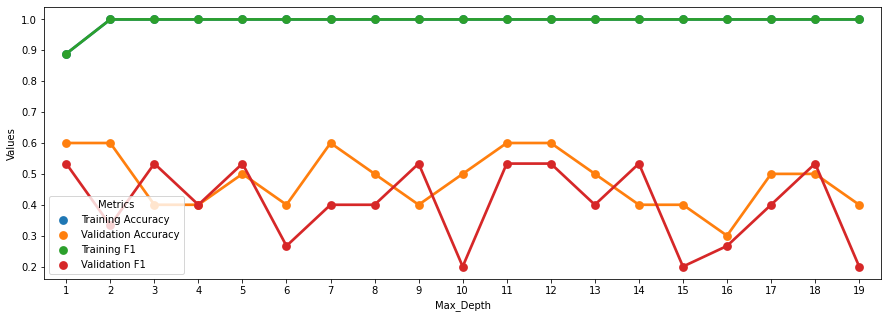

In [364]:
training_accuracy = []
val_accuracy = []
training_f1 = []
val_f1 = []
tree_depths = []

for depth in range(1,20):
    tree_clf = DecisionTreeClassifier(max_depth=depth)
    tree_clf.fit(X_train,y_train)
    y_training_pred = tree_clf.predict(X_train)

    training_acc = accuracy_score(y_train,y_training_pred)
    train_f1 = f1_score(y_train,y_training_pred)
    val_mean_f1 = cross_val_score(tree_clf,X_train,y_train,cv=5,scoring='f1_macro').mean()
    val_mean_accuracy = cross_val_score(tree_clf,X_train,y_train,cv=5,scoring='accuracy').mean()
    
    training_accuracy.append(training_acc)
    val_accuracy.append(val_mean_accuracy)
    training_f1.append(train_f1)
    val_f1.append(val_mean_f1)
    tree_depths.append(depth)
    

Tuning_Max_depth = {"Training Accuracy": training_accuracy, "Validation Accuracy": val_accuracy, "Training F1": training_f1, "Validation F1":val_f1, "Max_Depth": tree_depths }
Tuning_Max_depth_df = pd.DataFrame.from_dict(Tuning_Max_depth)

plot_df = Tuning_Max_depth_df.melt('Max_Depth',var_name='Metrics',value_name="Values")
fig,ax = plt.subplots(figsize=(15,5))
sns.pointplot(x="Max_Depth", y="Values",hue="Metrics", data=plot_df,ax=ax)

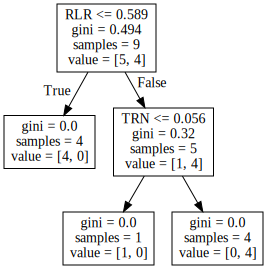

In [365]:
import graphviz 
from sklearn import tree

tree_clf = tree.DecisionTreeClassifier(max_depth = 3)
tree_clf.fit(X_train,y_train)
dot_data = tree.export_graphviz(tree_clf,feature_names = X.columns.tolist())
graph = graphviz.Source(dot_data)
graph

D:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
D:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
D:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
D:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
D:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least

D:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
D:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
D:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
D:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
D:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least

<AxesSubplot:xlabel='Min_Samples_leaf', ylabel='Values'>

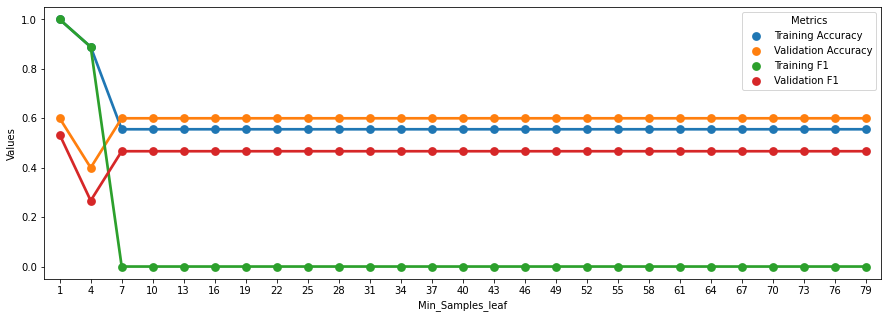

In [366]:
training_accuracy = []
val_accuracy = []
training_f1 = []
val_f1 = []
min_samples_leaf = []
import numpy as np
for samples_leaf in range(1,80,3): ### Sweeping from 1% samples to 10% samples per leaf 
    tree_clf = DecisionTreeClassifier(max_depth=3,min_samples_leaf = samples_leaf)
    tree_clf.fit(X_train,y_train)
    y_training_pred = tree_clf.predict(X_train)

    training_acc = accuracy_score(y_train,y_training_pred)
    train_f1 = f1_score(y_train,y_training_pred)
    val_mean_f1 = cross_val_score(tree_clf,X_train,y_train,cv=5,scoring='f1_macro').mean()
    val_mean_accuracy = cross_val_score(tree_clf,X_train,y_train,cv=5,scoring='accuracy').mean()
    
    training_accuracy.append(training_acc)
    val_accuracy.append(val_mean_accuracy)
    training_f1.append(train_f1)
    val_f1.append(val_mean_f1)
    min_samples_leaf.append(samples_leaf)
    

Tuning_min_samples_leaf = {"Training Accuracy": training_accuracy, "Validation Accuracy": val_accuracy, "Training F1": training_f1, "Validation F1":val_f1, "Min_Samples_leaf": min_samples_leaf }
Tuning_min_samples_leaf_df = pd.DataFrame.from_dict(Tuning_min_samples_leaf)

plot_df = Tuning_min_samples_leaf_df.melt('Min_Samples_leaf',var_name='Metrics',value_name="Values")
fig,ax = plt.subplots(figsize=(15,5))
sns.pointplot(x="Min_Samples_leaf", y="Values",hue="Metrics", data=plot_df,ax=ax)


In [367]:
from sklearn.metrics import confusion_matrix
tree_clf = DecisionTreeClassifier(max_depth=3,min_samples_leaf = 35)
tree_clf.fit(X_train,y_train)
y_pred = tree_clf.predict(X_test)
print("Test Accuracy: ",accuracy_score(y_test,y_pred))
print("Test F1 Score: ",f1_score(y_test,y_pred))
print("Confusion Matrix on Test Data")
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Test Accuracy:  0.6666666666666666
Test F1 Score:  0.0
Confusion Matrix on Test Data


Predicted,0,All
True,,
0,6,6
1,3,3
All,9,9


---CV SCORE--- 0.0
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         6
           1       0.00      0.00      0.00         3

    accuracy                           0.67         9
   macro avg       0.33      0.50      0.40         9
weighted avg       0.44      0.67      0.53         9



D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


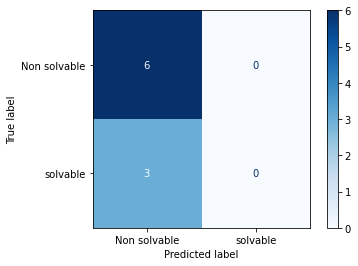

In [339]:
evaluation(tree_clf,X_train,y_train,X_test,y_test)

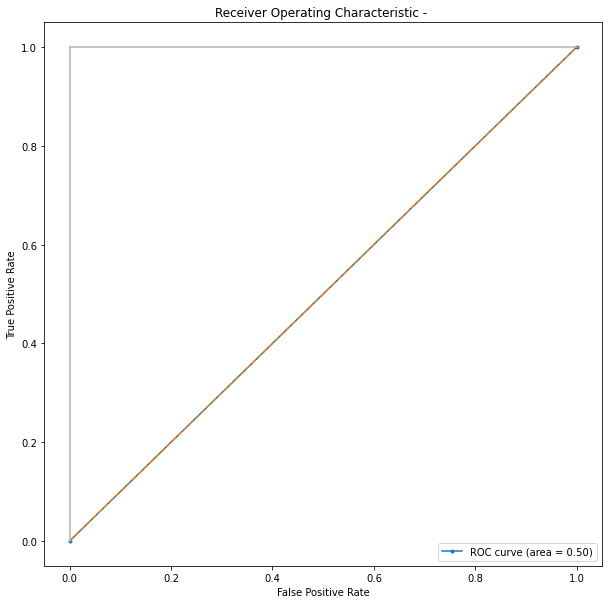

In [340]:
plot_roc(X_test,y_test,tree_clf)

##### Model 2: Random Forest Classifier

In [341]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100,max_depth=3,min_samples_leaf = 10)
rf_clf.fit(X_train,y_train)
y_pred = rf_clf.predict(X_train)
print("Train F1 Score ", f1_score(y_train,y_pred))
print("Train Accuracy ", accuracy_score(y_train,y_pred))

print("Validation Mean F1 Score: ",cross_val_score(rf_clf,X_train,y_train,cv=5,scoring='f1_macro').mean())
print("Validation Mean Accuracy: ",cross_val_score(rf_clf,X_train,y_train,cv=5,scoring='accuracy').mean())

Train F1 Score  0.0
Train Accuracy  0.5555555555555556


D:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Validation Mean F1 Score:  0.4666666666666666


D:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Validation Mean Accuracy:  0.4


In [342]:
y_pred = rf_clf.predict(X_test)
print("Test Accuracy: ",accuracy_score(y_test,y_pred))
print("Test F1 Score: ",f1_score(y_test,y_pred))
print("Confusion Matrix on Test Data")
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Test Accuracy:  0.6666666666666666
Test F1 Score:  0.0
Confusion Matrix on Test Data


Predicted,0,All
True,,
0,6,6
1,3,3
All,9,9


---CV SCORE--- 0.125
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         6
           1       0.00      0.00      0.00         3

    accuracy                           0.67         9
   macro avg       0.33      0.50      0.40         9
weighted avg       0.44      0.67      0.53         9



D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


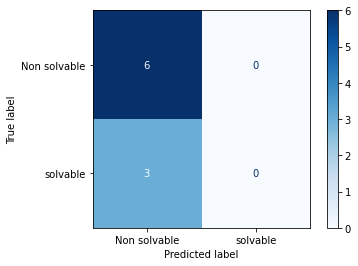

In [343]:
evaluation(rf_clf,X_train,y_train,X_test,y_test)

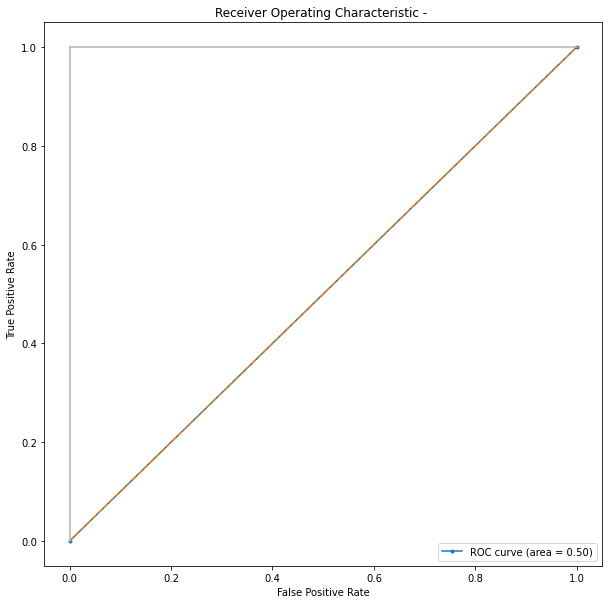

In [344]:
plot_roc(X_test,y_test,rf_clf)

##### Model 3: Logistic Regression

<AxesSubplot:xlabel='Decision Threshold', ylabel='Values'>

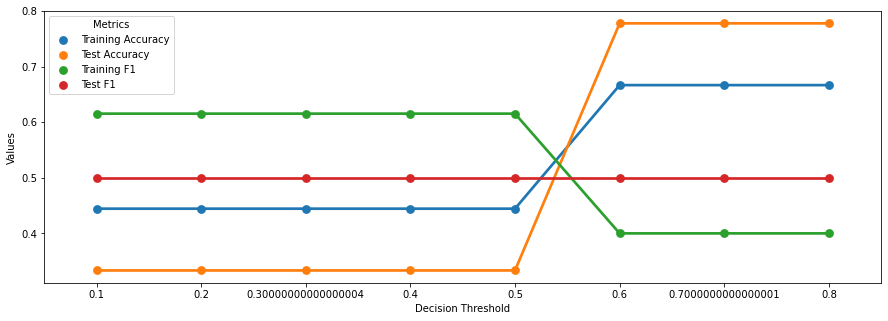

In [345]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict

train_accuracies = []
train_f1_scores = []
test_accuracies = []
test_f1_scores = []
thresholds = []

for thresh in np.arange(0.1,0.9,0.1): 
    logreg_clf = LogisticRegression(solver='liblinear')
    logreg_clf.fit(X_train,y_train)
    
    y_pred_train_thresh = logreg_clf.predict_proba(X_train)[:,1]
    y_pred_train = (y_pred_train_thresh > thresh).astype(int)

    train_acc = accuracy_score(y_train,y_pred_train)
    train_f1 = f1_score(y_train,y_pred_train)
    
    y_pred_test_thresh = logreg_clf.predict_proba(X_test)[:,1]
    y_pred_test = (y_pred_test_thresh > thresh).astype(int) 
    
    test_acc = accuracy_score(y_test,y_pred_test)
    test_f1 = f1_score(y_test,y_pred_test)
    
    train_accuracies.append(train_acc)
    train_f1_scores.append(train_f1)
    test_accuracies.append(test_acc)
    test_f1_scores.append(test_f1)
    thresholds.append(thresh)
    
    
Threshold_logreg = {"Training Accuracy": train_accuracies, "Test Accuracy": test_accuracies, "Training F1": train_f1_scores, "Test F1":test_f1_scores, "Decision Threshold": thresholds }
Threshold_logreg_df = pd.DataFrame.from_dict(Threshold_logreg)

plot_df = Threshold_logreg_df.melt('Decision Threshold',var_name='Metrics',value_name="Values")
fig,ax = plt.subplots(figsize=(15,5))
sns.pointplot(x="Decision Threshold", y="Values",hue="Metrics", data=plot_df,ax=ax)


In [346]:
thresh = 0.4 ### Threshold chosen from above Curves
y_pred_test_thresh = logreg_clf.predict_proba(X_test)[:,1]
y_pred = (y_pred_test_thresh > thresh).astype(int) 
print("Test Accuracy: ",accuracy_score(y_test,y_pred))
print("Test F1 Score: ",f1_score(y_test,y_pred))
print("Confusion Matrix on Test Data")
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Test Accuracy:  0.3333333333333333
Test F1 Score:  0.5
Confusion Matrix on Test Data


Predicted,1,All
True,,
0,6,6
1,3,3
All,9,9


---CV SCORE--- 0.45833333333333326
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.33      1.00      0.50         3

    accuracy                           0.33         9
   macro avg       0.17      0.50      0.25         9
weighted avg       0.11      0.33      0.17         9



D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


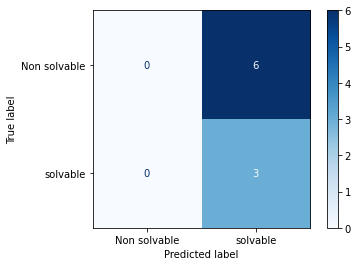

In [347]:
evaluation(logreg_clf,X_train,y_train,X_test,y_test)

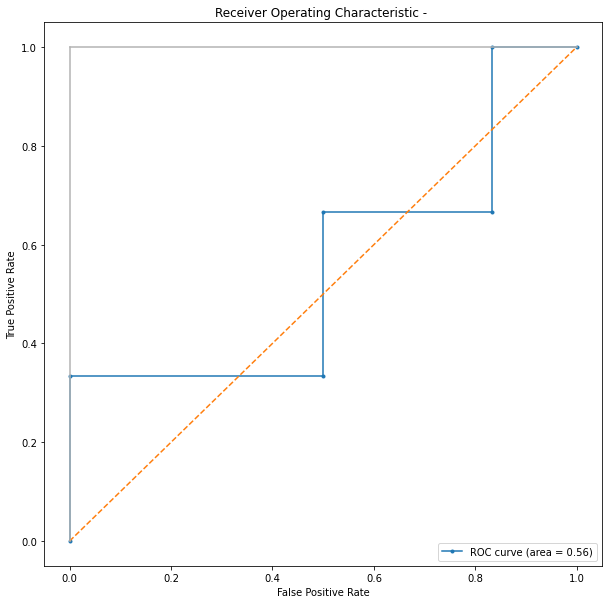

In [348]:
plot_roc(X_test,y_test,logreg_clf)

##### Model 4:knn

Text(0, 0.5, 'Erreur')

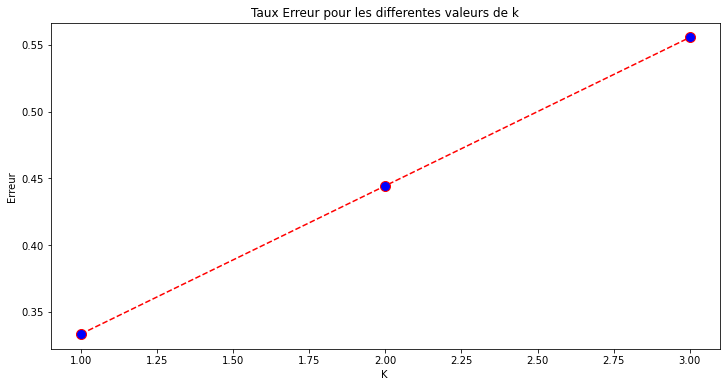

In [351]:
from sklearn.neighbors import KNeighborsClassifier

error = []
# Calculer l'erreur pour k entre 1 et 40 
#Pour chaque itération, l'erreur moyenne pour les valeurs prédites 
#de l'ensemble de test est calculée et sauvegardée ds la liste Erreur.
# Tester k de 1 à 40 et la distance Manhattan
for i in range(1, 4):
    knn = KNeighborsClassifier(i,metric='manhattan')
    knn_model = knn.fit(X_train, y_train)
    pred_i = knn_model.predict(X_test)
    error.append(np.mean(pred_i != y_test))
plt.figure(figsize=(12, 6))
plt.plot(range(1, 4), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Taux Erreur pour les differentes valeurs de k')
plt.xlabel('K ')
plt.ylabel('Erreur')

In [352]:
from sklearn.model_selection import GridSearchCV
leaf_size = list(range(1,20))# Par défaut c'est 30
n_neighbors = list(range(1,4))
p=[1,2] #p = 1 manhattan_distance/p=2 euclidean_distance
#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
#Create new KNN object
knn_2 = KNeighborsClassifier()
#Use GridSearch
clf = GridSearchCV(knn_2, hyperparameters, cv=2, n_jobs=-1)
#n_jobs: number of CPU'sfor execution.
#cv: number of folds of the cross validation

#Fit the model
best_model = clf.fit(X_train, y_train)
#Print The value of best Hyperparameters
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

Best leaf_size: 1
Best p: 1
Best n_neighbors: 1


In [353]:
best_model.best_estimator_.fit(X_train, y_train)

KNeighborsClassifier(leaf_size=1, n_neighbors=1, p=1)

---CV SCORE--- 0.6666666666666666
              precision    recall  f1-score   support

           0       0.57      0.67      0.62         6
           1       0.00      0.00      0.00         3

    accuracy                           0.44         9
   macro avg       0.29      0.33      0.31         9
weighted avg       0.38      0.44      0.41         9



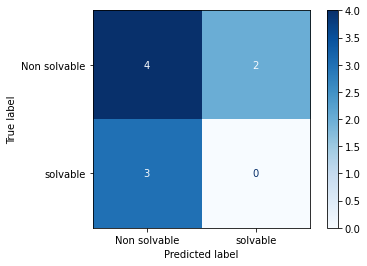

In [354]:
evaluation(knn,X_train,y_train,X_test,y_test)

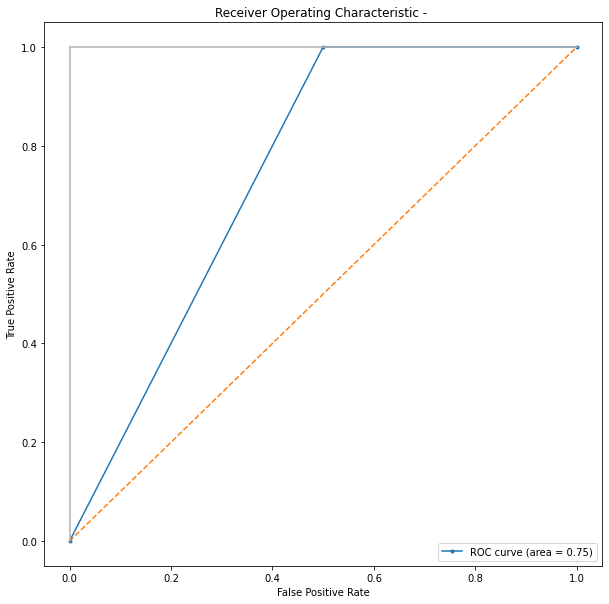

In [250]:
plot_roc(X_test,y_test,knn)

In [69]:
#django


In [ ]:
logreg_clf = joblib.load('final_model.sav')
    lis=[]
    lis.append(request.GET['TT'])

In [ ]:
filename='final_model.sav'
joblib.dump(cls,filename)

In [ ]:

    ans=logreg_clf.predict([lis])
    
    return render(request,'result.html',{'approval':ans})

In [ ]:
the result is {{ans}}
